# ----------------------- Model Training, validation, and testing --------------------------

In [1]:
## Some basic libraries 
import sys
import os
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy.stats as st

## Preprocessing:
#from sklearn.preprocessing import OneHotEncoder
#from sklearn.preprocessing import LabelEncoder
#from sklearn.preprocessing import StandardScaler

## Feature Selection: 
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import RFE, RFECV
#from sklearn.feature_selection import VarianceThreshold

## Model Selection:
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, RepeatedStratifiedKFold,StratifiedGroupKFold, cross_val_score

## Models:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Lasso, LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
import xgboost as xgb

## Evaluation Metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score,roc_curve, RocCurveDisplay, auc
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import make_scorer, f1_score, accuracy_score, average_precision_score, balanced_accuracy_score


from sklearn import __version__

print('python: {}'.format(sys.version))
print('Pandas: {}'.format(pd.__version__))
print('Numpy: {}'.format(np.__version__))
print('Sklearn: {}'.format(__version__))


#print('OS: {}'.format(os.__version__))
#print('Sklearn: {}'.format(sklearn.__version__))


python: 3.11.0 | packaged by conda-forge | (main, Oct 25 2022, 06:18:27) [GCC 10.4.0]
Pandas: 1.5.1
Numpy: 1.23.4
Sklearn: 1.1.3


# Data preparation: 

> # Import Datasets

In [2]:
%%time
df = pd.read_csv('/home/phoebe/phd/ML_csv/All_groups/All_groups_Label.csv', index_col='Unnamed: 0')

CPU times: user 6min 2s, sys: 3min 29s, total: 9min 32s
Wall time: 9min 32s


In [3]:
df.shape

(41, 569651)

In [4]:
df.tail(3)

,chr1-100000012,chr1-100007888,chr1-100011243,chr1-100011253,chr1-1000156,chr1-100015837,chr1-100015925,chr1-100019269,chr1-100022918,chr1-10002546,...,chrX-99969558,chrX-99972474,chrX-9997369,chrX-99974005,chrX-99979187,chrX-99990696,chrX-99995215,chrX-99997342,chrX-99997406,Y
G3_Sample_7_merged,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/1,...,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,moderate
G3_Sample_8_merged,0/0,0/0,0/1,0/1,0/0,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0,1/1,0/0,1/1,1/1,moderate
G3_Sample_9_merged,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,1/1,0/0,...,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,moderate


> # X-y split

In [5]:
X = df.iloc[:,:-1]

In [6]:
X.shape

(41, 569650)

In [7]:
X.isnull().any().sum()

0

In [8]:
y = df[['Y']]

In [9]:
df['Y'].value_counts()

Severe      22
moderate    19
Name: Y, dtype: int64

In [10]:
y.head(3)

,Y
G1_Sample_006_merged,moderate
G1_Sample_007_merged,Severe
G1_Sample_013_merged,Severe


> # Encoding categorical features

>## SNPs Encoding
* Now we want to convert datatype of every SNP from object (0/0, 0/1, 1/1) to numerical values (0, 1, 2) respectively  which reflects the number of minor allele in each genotype so that we can apply different ML algorithms on them. 

>## Target variable Encoding
* Y values are replaced from ('Severe', 'moderate') to (1,0) respectively 

In [11]:
X_coded = X.replace(['0/0', '0/1', '1/1'],[0,1,2])

In [12]:
X_coded.tail(3)

,chr1-100000012,chr1-100007888,chr1-100011243,chr1-100011253,chr1-1000156,chr1-100015837,chr1-100015925,chr1-100019269,chr1-100022918,chr1-10002546,...,chrX-99961072,chrX-99969558,chrX-99972474,chrX-9997369,chrX-99974005,chrX-99979187,chrX-99990696,chrX-99995215,chrX-99997342,chrX-99997406
G3_Sample_7_merged,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
G3_Sample_8_merged,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,2,2
G3_Sample_9_merged,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
y_coded = y['Y'].replace(['Severe','moderate'], [1,0])

In [14]:
y_coded.head(3)

G1_Sample_006_merged    0
G1_Sample_007_merged    1
G1_Sample_013_merged    1
Name: Y, dtype: int64

> # Train-Test Split

In [15]:
## The train-test split is done taking into consideration the 'stratify=' option because our data is not perfectly balanced

X_train, X_test, y_train, y_test = train_test_split(X_coded, y_coded ,test_size=0.25,stratify=y_coded, random_state= 2023)
X_train.shape , X_test.shape, y_train.shape , y_test.shape

((30, 569650), (11, 569650), (30,), (11,))

# Feature Selection:
# Basic Filter Methods For Feature Selection

> # Removing Constant & Quasi Constant features

In [16]:
%%time
# create an empty list
quasi_constant_feat = []

# iterate over every feature
for feature in tqdm(X_train.columns):

    # find the predominant value, that is the value that is shared
    # by most observations
    predominant = X_train[feature].value_counts(
        normalize=True).sort_values(ascending=False).values[0]

    # evaluate the predominant feature: if we find 1 observation only to be different out of the 30 in the train set, and the remaining 29 have the same value 
    ## this means that this feature will not be useful in discriminatin the two classes 
    # show 1 value? i.e. the percentage of the predominant value is = 0.967 i.e. 29 out of 30 take the same value
    if predominant >= 0.967:

        # if yes, add the variable to the list
        quasi_constant_feat.append(feature)

len(quasi_constant_feat)

  0%|          | 0/569650 [00:00<?, ?it/s]

CPU times: user 3min 9s, sys: 2min 30s, total: 5min 39s
Wall time: 5min 24s


133473

In [17]:
quasi_constant_feat[-10:-1]

['chrX-99926084',
 'chrX-99928949',
 'chrX-99939942',
 'chrX-99943074',
 'chrX-99953672',
 'chrX-99961072',
 'chrX-99972474',
 'chrX-99974005',
 'chrX-99979187']

### We can see that 133473 columns / variables are almost constant. This means that 133473 variables show predominantly one value for the majority or all of the observations of the training set. Let's explore a few if these variables below.
these features were found in train dataset and removed from both X_train and X_test datasets to avoid information leakage

In [18]:
# select one feature from the list

quasi_constant_feat[-1]

'chrX-99995215'

In [19]:
X_train['chrX-99926084'].value_counts(normalize=True)

0    1.0
Name: chrX-99926084, dtype: float64

In [20]:
# finally, let's drop the quasi-constant features:

X_train_QC = X_train.drop(labels=quasi_constant_feat, axis=1)
X_test_QC = X_test.drop(labels=quasi_constant_feat, axis=1)

print(X_train.shape, X_test.shape)
#print(X_train_C.shape, X_test_C.shape)
print(X_train_QC.shape, X_test_QC.shape)

(30, 569650) (11, 569650)
(30, 436177) (11, 436177)


### Now, we removed (23.43% of features) of the original variables!!! We passed from 569650 variables to 436177.

> # Removing Duplicate Features

In [21]:
%%time
## To remove duplicate columns from the train dataset:
## First we transpose the dataframe and make our features(SNPs) as rows and samples as columns 
## Second use the drop_duplicate() method to drop duplicate rows in just few seconds
## Third we apply the Transpose again to the data frame to return to the original shape with features (SNPs) as columns and samples as rows 

X_train_Dup = X_train_QC.T.drop_duplicates().T

CPU times: user 567 ms, sys: 1.48 ms, total: 568 ms
Wall time: 566 ms


In [22]:
len(X_train_Dup.columns)

63089

In [23]:
## Now we want to know how many features were dropped && The name of these features to use them to drop same set of features from the test set as well: 
## we make small for loop to compare column names in test data having all columns with column names in train data having only subset of columns after duplicate removal
## if a column name from test set was found in train set, then append this name in a created list 'features_in' because those are the features which will be used in the further analysis steps 
## if a column name from test set was NOT found in train set, append this name in a created list 'features_out' because those are the features which will be dropped from the test set
## so that both train and test sets have same set of features

features_in = []
features_out = []

for i in X_test_QC.columns:
    if i in X_train_Dup.columns:
        features_in.append(i)
    else:
        features_out.append(i)

In [24]:
print (len(features_in))
print (len(features_out))

63089
373088


In [25]:
X_test_Dup = X_test_QC.drop(features_out, axis=1)


print(X_train_QC.shape, X_test_QC.shape)
print(X_train_Dup.shape, X_test_Dup.shape)

(30, 436177) (11, 436177)
(30, 63089) (11, 63089)


### Now, we removed (88.92 % of features) of the original variables!!! We passed from 569650 variables to 63089.

To avoid memory overload each time we load the whole df with more than half million SNPs, I will concat X_train and X_test after removal of 88.92% of the constant, quasi constant, and Duplicate features 
and then sort them by rows and concat the Label (Target) variable to make a new dataframe from which I begin my further analysis from this step 

In [28]:
%%time
X_New = pd.concat ([X_train_Dup, X_test_Dup], axis= 0)
X_3groups_Dup= X_New.sort_index(axis=0)
df_3groups_Dup = pd.concat([X_3groups_Dup, y_coded], axis=1)
df_3groups_Dup.to_csv('/home/phoebe/phd/ML_csv/Precious_DF/df_3groups_Dup_75_25.csv')

CPU times: user 2.66 s, sys: 8.99 ms, total: 2.67 s
Wall time: 2.68 s


# --------------------------   ###    Quick  START ###  -------------------------------                       

> # Import Data with removed Constant, Quasi Constant, and Duplicate features
Import new smaller sized DataFrame after removal of all constant, quasi constant and Duplicate features

In [2]:
%%time
df_3groups_Dup = pd.read_csv('/home/phoebe/phd/ML_csv/Precious_DF/df_3groups_Dup_75_25.csv', index_col='Unnamed: 0')
df_3groups_Dup.shape

CPU times: user 1.76 s, sys: 1.69 s, total: 3.45 s
Wall time: 3.47 s


(41, 63090)

In [3]:
df_3groups_Dup

,chr1-100007888,chr1-100011243,chr1-100015925,chr1-100022918,chr1-10002546,chr1-10002921,chr1-10004350,chr1-100045481,chr1-100058793,chr1-10007418,...,chrX-99930886,chrX-99930892,chrX-99933154,chrX-99936147,chrX-99943244,chrX-99943560,chrX-99945176,chrX-99956157,chrX-99957136,Y
G1_Sample_006_merged,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
G1_Sample_007_merged,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
G1_Sample_013_merged,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
G1_Sample_014_merged,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
G1_Sample_015_merged,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
G1_Sample_017_merged,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
G1_Sample_021_merged,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
G1_Sample_022_merged,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
G1_Sample_024_merged,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
G2_Sample_11_merged,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,1,1,0,1


> # X-y split

In [4]:
X = df_3groups_Dup.iloc[:,:-1]

In [5]:
y = df_3groups_Dup[['Y']]

In [6]:
y['Y'].value_counts()

1    22
0    19
Name: Y, dtype: int64

> # Train - Test split

In [7]:
## The train-test split is done taking into consideration the 'stratify=' option because our data is not perfectly balanced

X_train_Dup, X_test_Dup, y_train, y_test = train_test_split(X, y ,test_size=0.25,stratify=y, random_state=2023)
X_train_Dup.shape , X_test_Dup.shape, y_train.shape , y_test.shape

((30, 63089), (11, 63089), (30, 1), (11, 1))

# Feature Selection:
# More Methods For Feature Selection

> # Select Features with univariate DT-ML model
##### Univariate roc-auc (any other metric can be used)
This procedure works as follows:

* First, we build one decision tree per feature, to predict the target
* Second, we make predictions using the decision tree and the mentioned feature
* Third, we measure the performance of that prediction, in our case we choosed the roc_auc 
* Fourth, we rank the features according to the machine learning metric (roc-auc)
* We select the highest ranking features (roc_auc >= 0.8)

In [8]:
%%time
# determine roc-auc for each feature

# here we store the roc-auc values
roc_values = []

# iterate over each feature in the dataset
for feature in tqdm(X_train_Dup.columns):

    # train a decision tree classifier
    clf = DecisionTreeClassifier(random_state= 42)
    clf.fit(X_train_Dup[feature].to_frame(), y_train)

    # obtain the predictions
    y_scored = clf.predict_proba(X_test_Dup[feature].to_frame())

    # calculate and store the roc-auc
    roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))
    
# display the result
roc_values[0:10]

  0%|          | 0/63089 [00:00<?, ?it/s]

CPU times: user 4min 25s, sys: 13.7 s, total: 4min 39s
Wall time: 4min 37s


[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.43333333333333335, 0.5]

Text(0, 0.5, 'roc-auc')

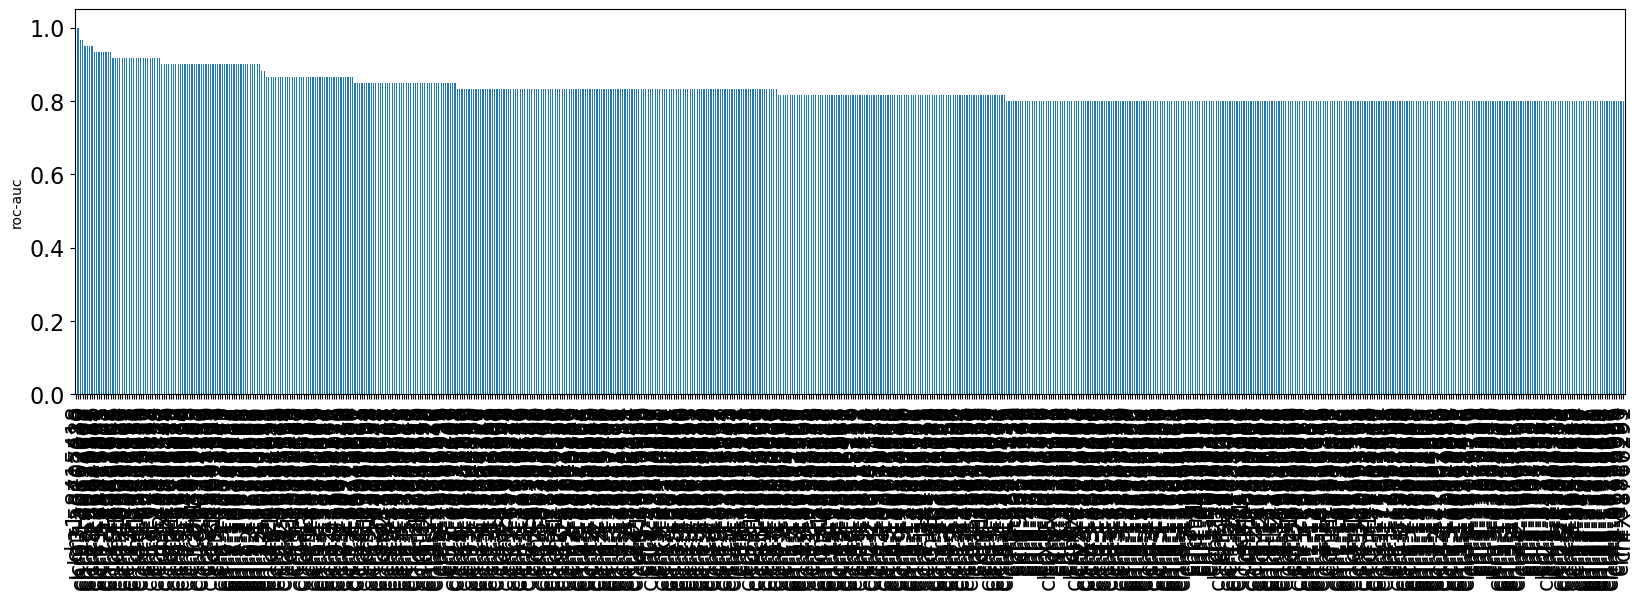

In [9]:
# now let's:

# 1) capture the roc-auc values in a pandas series
# 2) add the variable names in the index
# 3) sort the features based on the roc-auc
# 4) and make a var plot

roc_values = pd.Series(roc_values)
roc_values.index = X_train_Dup.columns
roc_values[roc_values >= 0.8].sort_values(ascending=False).plot.bar(figsize=(20, 5), fontsize = 16)
plt.ylabel('roc-auc')

In [10]:
# a roc auc value of 0.8 indicates confident decision of 80% 
# let's check how many features show a roc-auc value
# higher than or equal to 0.8
roc_values = pd.Series(roc_values)
roc_values.index = X_train_Dup.columns
len(roc_values[roc_values >= 0.8])

666

In [11]:
#Select features with roc-auc >= 0.8
selected_features_DT = roc_values[roc_values >= 0.8].index

print(selected_features_DT)

Index(['chr1-100342227', 'chr1-100343073', 'chr1-100345409', 'chr1-100358103',
       'chr1-100376448', 'chr1-108734993', 'chr1-109349879', 'chr1-109726695',
       'chr1-109796053', 'chr1-110210818',
       ...
       'chrX-40573774', 'chrX-44494967', 'chrX-45060191', 'chrX-47065186',
       'chrX-53652838', 'chrX-53652844', 'chrX-55248376', 'chrX-55249049',
       'chrX-68393892', 'chrX-8766291'],
      dtype='object', length=666)


In [12]:
# select features in the dataframes

X_train_univariate_DT = X_train_Dup[selected_features_DT]
X_test_univariate_DT = X_test_Dup[selected_features_DT]

#print(X_train_QC.shape, X_test_QC.shape)
print(X_train_Dup.shape, X_test_Dup.shape)
print(X_train_univariate_DT.shape, X_test_univariate_DT.shape)
print(y_train.shape, y_test.shape)

(30, 63089) (11, 63089)
(30, 666) (11, 666)
(30, 1) (11, 1)


> # Correlation Feature Selection
#### Finding correlations between features that resulted after selction using single ML algorithm for each feature

### Identify groups of highly correlated features

Now we looks to identify groups of highly correlated features. And then, we can make further investigation within these groups to decide which feature we keep and which one we remove.

In [13]:
%%time
# build a dataframe with the correlation between features
# remember that the absolute value of the correlation
# coefficient is important and not the sign

corrmat = X_train_univariate_DT.corr(method= 'spearman')
corrmat = corrmat.abs().unstack() # absolute value of corr coef
corrmat = corrmat.sort_values(ascending=False)
corrmat = corrmat[corrmat >= 0.7]
corrmat = corrmat[corrmat < 1]
corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ['feature1', 'feature2', 'corr']
print(corrmat.shape)
corrmat.head()


(1462, 3)
CPU times: user 182 ms, sys: 72.5 ms, total: 255 ms
Wall time: 256 ms


,feature1,feature2,corr
0,chr22-18717939,chr9-115983540,0.998082
1,chr9-115983540,chr22-18717939,0.998082
2,chr1-207749188,chr1-207726000,0.997344
3,chr1-207726000,chr1-207749188,0.997344
4,chr3-38047680,chr3-38050159,0.996546


In [14]:
len(corrmat['feature1'].unique())

495

In [15]:
### Here we want to find features that are un-correlated OR has a correlation coefficient less than 0.7

uncorr_predictors = []
for col in X_train_univariate_DT.columns:
    if col not in corrmat['feature1'].unique():
        uncorr_predictors.append(col)
print(len(uncorr_predictors))        

171


In [16]:
correlated_block = corrmat[corrmat.feature1 == 'chr3-38047680']
correlated_block 

,feature1,feature2,corr
4,chr3-38047680,chr3-38050159,0.996546
679,chr3-38047680,chr3-38047211,0.754330


In [17]:
grouped_feature_ls = list(correlated_block.feature2.unique()) + ['chr3-38047680']
len(grouped_feature_ls)

3

In [18]:
# find groups of correlated features

grouped_feature_ls = []
correlated_groups = []

for feature in tqdm(corrmat.feature1.unique()):
    
    if feature not in grouped_feature_ls:

        # find all features correlated to a single feature
        correlated_block = corrmat[corrmat.feature1 == feature]
        grouped_feature_ls = grouped_feature_ls + list(
            correlated_block.feature2.unique()) + [feature]

        # append the block of features to the list
        correlated_groups.append(correlated_block)

print('found {} correlated groups'.format(len(correlated_groups)))
print('out of {} total features'.format(X_train_univariate_DT.shape[1]))

  0%|          | 0/495 [00:00<?, ?it/s]

found 213 correlated groups
out of 666 total features


In [19]:
len (correlated_groups)

213

* Now we can build a machine learning algorithm for every correlated group, and select the most predictive feature and discard the rest within that correlated group
.

In [20]:
%%time

most_important_features = []
for group in tqdm(correlated_groups):
    # add all features of that specific group to a list
    features_in_group = list(group['feature2'].unique())
    features_in_group.extend(group['feature1'].unique())
    print('there are {} correlated featureas '.format(len(features_in_group)))
    # train a random forest 
    rf = RandomForestClassifier(n_estimators=100, random_state=2023, max_depth=4)
    rf.fit(X_train_univariate_DT[features_in_group], np.ravel(y_train))
    # get the feature importance attributed by the random forest model

    importance = pd.concat([pd.Series(features_in_group),pd.Series(rf.feature_importances_)], axis=1)
    importance.columns = ['feature', 'importance']

    # sort features by importance, most important first
    importance.sort_values(by='importance', ascending=False)
    if importance['feature'][0] not in most_important_features:
        most_important_features.append(importance['feature'][0])
print (len(most_important_features))

  0%|          | 0/213 [00:00<?, ?it/s]

there are 2 correlated featureas 
there are 2 correlated featureas 
there are 3 correlated featureas 
there are 6 correlated featureas 
there are 3 correlated featureas 
there are 11 correlated featureas 
there are 8 correlated featureas 
there are 6 correlated featureas 
there are 10 correlated featureas 
there are 7 correlated featureas 
there are 8 correlated featureas 
there are 3 correlated featureas 
there are 9 correlated featureas 
there are 5 correlated featureas 
there are 8 correlated featureas 
there are 3 correlated featureas 
there are 4 correlated featureas 
there are 6 correlated featureas 
there are 2 correlated featureas 
there are 3 correlated featureas 
there are 3 correlated featureas 
there are 4 correlated featureas 
there are 5 correlated featureas 
there are 3 correlated featureas 
there are 3 correlated featureas 
there are 6 correlated featureas 
there are 2 correlated featureas 
there are 3 correlated featureas 
there are 3 correlated featureas 
there are 3 

In [21]:
len(most_important_features)

178

In [22]:
final_selected_feat = most_important_features + uncorr_predictors
print(len(most_important_features))
print(len(uncorr_predictors))
print(len(final_selected_feat))

178
171
349


In [23]:
# select features in the dataframes

X_train_uncorr = X_train_univariate_DT[final_selected_feat]
X_test_uncorr = X_test_univariate_DT[final_selected_feat]

#print(X_train_QC.shape, X_test_QC.shape)
print(X_train_Dup.shape, X_test_Dup.shape)
print(X_train_univariate_DT.shape, X_test_univariate_DT.shape)
print(X_train_uncorr.shape, X_test_uncorr.shape)
print(y_train.shape, y_test.shape)

(30, 63089) (11, 63089)
(30, 666) (11, 666)
(30, 349) (11, 349)
(30, 1) (11, 1)


# After appplying successive feature selection methods the final number of features that will be used in model training and testing are N= 349

# Feature Selection: with Regularized Binary Logistic classifier

>> # Grid Search for LR hyperparameter tuning

In [51]:
%%time

# First create an instance of the choosen model 
logModel = LogisticRegression(max_iter=10000, random_state=2023)

# Create the parameter grid
param_grid = [    
    {'penalty' : ['l1','l2'],
     'solver' : ['liblinear'],
    'C' : [.001, .01, .1, 1, 10]},
    {'penalty' : ['l1', 'l2'],
                 'solver' : ['saga'],
                 'C' : [.001, .01, .1, 1, 10]},
    {'penalty' : ['elasticnet'],
                     'solver' : ['saga'],
                     'C' : [.001, .01, .1, 1, 10],
                     'l1_ratio' : [0.3, 0.5, 0.7, 0.9]}
    ]



# create 25 splits by repeating 5 Kfolds 5 times with different randomization in each repetition
cv= StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# gridsearchcv hypertunning of logestic model by using 25 splits and use different metric for scoring
Logistic_gridSearch1 = GridSearchCV(estimator=logModel, 
                                    param_grid = param_grid, 
                                    cv = cv, 
                                    return_train_score=True,
                                    scoring='roc_auc', verbose=3,
                                    n_jobs=-1, refit=True)

# fit the logestic model using each combination of parameters created by gridsearch
Logistic_gridSearch1.fit(X_train_Dup, np.ravel(y_train)) 

Fitting 5 folds for each of 40 candidates, totalling 200 fits
CPU times: user 1min 53s, sys: 1.97 s, total: 1min 55s
Wall time: 1h 14min 19s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=LogisticRegression(max_iter=10000, random_state=2023),
             n_jobs=-1,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10],
                          'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
                         {'C': [0.001, 0.01, 0.1, 1, 10],
                          'penalty': ['l1', 'l2'], 'solver': ['saga']},
                         {'C': [0.001, 0.01, 0.1, 1, 10],
                          'l1_ratio': [0.3, 0.5, 0.7, 0.9],
                          'penalty': ['elasticnet'], 'solver': ['saga']}],
             return_train_score=True, scoring='roc_auc', verbose=3)

In [52]:
# the best hyperparameters are stored in an attribute
Logistic_gridSearch1.best_estimator_

LogisticRegression(C=0.1, l1_ratio=0.3, max_iter=10000, penalty='elasticnet',
                   random_state=2023, solver='saga')

In [53]:

coeff = pd.DataFrame(Logistic_gridSearch1.best_estimator_.coef_,columns=X_train_Dup.columns).T
coeff.columns = ['coeff']
df = coeff[(coeff['coeff']>0) ]
df.sort_values(by='coeff', ascending=False)
df.index

Index(['chr1-145588184', 'chr1-156314627', 'chr1-156785617', 'chr1-156848995',
       'chr1-212985840', 'chr1-237144513', 'chr1-62728784', 'chr1-67685443',
       'chr2-106993152', 'chr2-1532929', 'chr2-167149693', 'chr2-167162277',
       'chr2-198127641', 'chr2-198127648', 'chr2-198127654', 'chr2-70020770',
       'chr2-89853211', 'chr22-19197896', 'chr22-19220648', 'chr22-24269730',
       'chr22-36633025', 'chr22-50942497', 'chr22-51043278', 'chr22-51045480',
       'chr3-38949363', 'chr3-38951753', 'chr3-39685529', 'chr3-57047089',
       'chr9-123920563', 'chr9-126132329', 'chr9-139393175', 'chr9-16791894',
       'chr9-19317022', 'chr9-44876151', 'chr9-66822789', 'chr9-79655569',
       'chr9-80145324', 'chr9-96434411'],
      dtype='object')

In [54]:
Regularized_features= list(df.index)
len(Regularized_features)

38

In [24]:
Regularized_features = ['chr1-145588184', 'chr1-156314627', 'chr1-156785617', 'chr1-156848995',
       'chr1-212985840', 'chr1-237144513', 'chr1-62728784', 'chr1-67685443',
       'chr2-106993152', 'chr2-1532929', 'chr2-167149693', 'chr2-167162277',
       'chr2-198127641', 'chr2-198127648', 'chr2-198127654', 'chr2-70020770',
       'chr2-89853211', 'chr22-19197896', 'chr22-19220648', 'chr22-24269730',
       'chr22-36633025', 'chr22-50942497', 'chr22-51043278', 'chr22-51045480',
       'chr3-38949363', 'chr3-38951753', 'chr3-39685529', 'chr3-57047089',
       'chr9-123920563', 'chr9-126132329', 'chr9-139393175', 'chr9-16791894',
       'chr9-19317022', 'chr9-44876151', 'chr9-66822789', 'chr9-79655569',
       'chr9-80145324', 'chr9-96434411']

In [25]:
# select features in the dataframes

X_train_Regularized = X_train_Dup[Regularized_features]
X_test_Regularized = X_test_Dup[Regularized_features]

print(X_train_Dup.shape, X_test_Dup.shape)
print(X_train_uncorr.shape, X_test_uncorr.shape)
print (X_train_Regularized.shape, X_test_Regularized.shape)
print(y_train.shape, y_test.shape)

(30, 63089) (11, 63089)
(30, 349) (11, 349)
(30, 38) (11, 38)
(30, 1) (11, 1)


# Nested Cross-Validation

In [26]:
X_train_uncorr_copy = X_train_uncorr.reset_index(drop=True)
X_train_Dup_copy = X_train_Dup.reset_index(drop=True)
X_train_Regularized_copy = X_train_Regularized.reset_index(drop=True)
y_train_copy = y_train.reset_index(drop=True)

In [58]:
def nested_cross_val(model, grid, X_train, y_train):

    # configure the outer loop cross-validation procedure
    cv_outer = StratifiedKFold(n_splits=10, shuffle=True, random_state=2023)

    # configure the inner loop cross-validation procedure
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=2023)

    # enumerate splits
    outer_results = list()
    inner_results = list()

    for train_ix, test_ix in cv_outer.split(X_train, y_train):

        # split data
        xtrain, xtest = X_train.loc[train_ix, :], X_train.loc[test_ix, :]
        ytrain, ytest = y_train.loc[train_ix], y_train.loc[test_ix]


        # define search
        search = GridSearchCV(
            model, grid, scoring='roc_auc', cv=cv_inner, refit=True)

        # execute search
        search.fit(xtrain, np.ravel(ytrain))

        print('\n        Best ROC_AUC (avg. of inner test folds) %.3f%%' % (search.best_score_ ))
        print('        Best parameters:', search.best_params_)
        
        # evaluate model on the hold out dataset
        yhat = search.predict(xtest)

        # evaluate the model
        ROC_AUC = roc_auc_score(ytest, yhat)
        print('        ROC_AUC (on outer test fold) %.3f%%' % (ROC_AUC))

        # store the result
        outer_results.append(ROC_AUC)

        inner_results.append(search.best_score_)      

    # summarize the estimated performance of the model

    print('\n    Outer Loop:')
    print('        ROC_AUC %.3f%% +/- %.3f' % 
              (np.mean(outer_results), np.std(outer_results) ))
    
    # # create 95% confidence interval
    # print(f'lower limit, upper limit : {st.t.interval(confidence=0.95, df=len(outer_results)-1,loc=np.mean(outer_results),scale=st.sem(outer_results))}')

    print('\n    Iner Loop:')
    print('       ROC_AUC %.2f%% +/- %.2f' %
           (np.mean(inner_results), np.std(inner_results)))
    
    return search.fit(X_train, np.ravel(y_train))


# KNN

In [59]:
# First create the base model to tune
KNN = KNeighborsClassifier()

# Create the parameter grid
KNN_param = { 'n_neighbors': [3, 5, 7, 10],
             'weights' : ['uniform', 'distance'],
         'metric' : ['euclidean', 'manhattan', 'minkowski', 'cosine'],
         'leaf_size': range(1,25,5)
}

In [60]:
%%time
KNN_search1 = nested_cross_val(KNN, KNN_param, X_train_uncorr_copy, y_train_copy)


        Best ROC_AUC (avg. of inner test folds) 0.700%
        Best parameters: {'leaf_size': 1, 'metric': 'cosine', 'n_neighbors': 10, 'weights': 'distance'}
        ROC_AUC (on outer test fold) 0.500%

        Best ROC_AUC (avg. of inner test folds) 0.567%
        Best parameters: {'leaf_size': 1, 'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}
        ROC_AUC (on outer test fold) 0.500%

        Best ROC_AUC (avg. of inner test folds) 0.578%
        Best parameters: {'leaf_size': 1, 'metric': 'cosine', 'n_neighbors': 10, 'weights': 'distance'}
        ROC_AUC (on outer test fold) 0.500%

        Best ROC_AUC (avg. of inner test folds) 0.639%
        Best parameters: {'leaf_size': 1, 'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
        ROC_AUC (on outer test fold) 0.250%
[CV 2/5] END C=0.001, penalty=l1, solver=liblinear;, score=(train=0.500, test=0.500) total time=   1.8s
[CV 4/5] END C=0.001, penalty=l2, solver=liblinear;, score=(train=1.000, test

In [61]:
KNN_search1.best_params_

{'leaf_size': 1,
 'metric': 'manhattan',
 'n_neighbors': 5,
 'weights': 'distance'}

In [62]:
KNN_search1.best_estimator_

KNeighborsClassifier(leaf_size=1, metric='manhattan', weights='distance')

In [63]:
# External Test:

# First create the base model to tune
KNN12 = KNeighborsClassifier(**KNN_search1.best_params_)

KNN12.fit(X_train_uncorr, np.ravel(y_train))

Y_train_pred_KNN = KNN12.predict(X_train_uncorr)
Y_test_pred_KNN = KNN12.predict(X_test_uncorr)
train_ROC_KNN = roc_auc_score(y_train, Y_train_pred_KNN)
test_ROC_KNN = roc_auc_score(y_test, Y_test_pred_KNN)

print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
## Evaluating the Model 

confidence = 0.95  # Change to your desired confidence level
z_value = st.norm.ppf((1 + confidence) / 2.0)
print(f'z_value: {z_value}')

print (f'Accuracy-score of KNN tunned model on train data: {round(accuracy_score(y_train,Y_train_pred_KNN),3)}')
print (f'Accuracy-score of KNN tunned model on test data: {round(accuracy_score(y_test,Y_test_pred_KNN),3)}')

ACC_testKNN = accuracy_score(y_test,Y_test_pred_KNN)
ci_length = z_value * np.sqrt((ACC_testKNN * (1 - ACC_testKNN)) / y_test.shape[0])
ci_lower = ACC_testKNN - ci_length
ci_upper = ACC_testKNN + ci_length
print(f'Test-set ACC lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

print (f'ROC-AUC-score of KNN tunned model on train data: {round(roc_auc_score(y_train,Y_train_pred_KNN),3)}')
print (f'ROC-AUC-score of KNN tunned model on test data: {round(roc_auc_score(y_test,Y_test_pred_KNN),3)}')

ROC_test = roc_auc_score(y_test,Y_test_pred_KNN)
ci_length = z_value * np.sqrt((ROC_test * (1 - ROC_test)) / y_test.shape[0])
ci_lower = ROC_test - ci_length
ci_upper = ROC_test + ci_length
print(f'Test-set ROC_AUC lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print() 

print (f'F1-score of KNN tunned model on train data: {round(f1_score(y_train,Y_train_pred_KNN),3)}')
print (f'F1-score of KNN tunned model on test data: {round(f1_score(y_test,Y_test_pred_KNN),3)}')

F1_test = f1_score(y_test,Y_test_pred_KNN)
ci_length = z_value * np.sqrt((F1_test * (1 - F1_test)) / y_test.shape[0])
ci_lower = F1_test - ci_length
ci_upper = F1_test + ci_length
print(f'Test-set F1 lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

print (f'PPV = Percision_score of KNN tunned model on train data: {round(precision_score(y_train,Y_train_pred_KNN),3)}')
print (f'PPV = Percision_score of KNN tunned model on test data: {round(precision_score(y_test,Y_test_pred_KNN),3)}')

Precision_test = precision_score(y_test,Y_test_pred_KNN)
ci_length = z_value * np.sqrt((Precision_test * (1 - Precision_test)) / y_test.shape[0])
ci_lower = Precision_test - ci_length
ci_upper = Precision_test + ci_length
print(f'Test-set Precision lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

print (f'PR_AUC of KNN tunned model on train data: {round(average_precision_score(y_train,Y_train_pred_KNN),3)}')
print (f'PR_AUC of KNN tunned model on test data: {round(average_precision_score(y_test,Y_test_pred_KNN),3)}')

PR_test = average_precision_score(y_test,Y_test_pred_KNN)
ci_length = z_value * np.sqrt((PR_test * (1 - PR_test)) / y_test.shape[0])
ci_lower = PR_test - ci_length
ci_upper = PR_test + ci_length
print(f'Test-set PR_AUC lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

print (f'TPR = Recall_score of KNN tunned model on train data: {round(recall_score(y_train,Y_train_pred_KNN),3)}')
print (f'TPR = Recall_score of KNN tunned model on test data: {round(recall_score(y_test,Y_test_pred_KNN),3)}')

Recall_test = recall_score(y_test,Y_test_pred_KNN)
ci_length = z_value * np.sqrt((Recall_test * (1 - Recall_test)) / y_test.shape[0])
ci_lower = Recall_test - ci_length
ci_upper = Recall_test + ci_length
print(f'Test-set RECALL lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

CM = confusion_matrix(y_test,Y_test_pred_KNN)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
TNR = TN/(TN+FP)
fnr = FN/(FN+TP)
fpr = FP/(TN+FP)

CM_train = confusion_matrix(y_train,Y_train_pred_KNN)
TN_train = CM_train[0][0]
FN_train = CM_train[1][0]
TP_train = CM_train[1][1]
FP_train = CM_train[0][1]
TNR_train = TN_train/(TN_train+FP_train)
fnr_train = FN_train/(FN_train+TP_train)
fpr_train = FP_train/(TN_train+FP_train)



## FNR = 1 - TPR and TPR = recall
## FNR = 1 - Recall
FNR_train = 1-round(recall_score(y_train,Y_train_pred_KNN),3)
FNR_test = 1-round(recall_score(y_test,Y_test_pred_KNN),3)

print(f'False Negative Rate of KNN tunned model on train data: {round(FNR_train,3)}')
print(f'False Negative Rate of KNN tunned model on test data: {round(FNR_test,3)}')

ci_length = z_value * np.sqrt((FNR_test * (1 - FNR_test)) / y_test.shape[0])
ci_lower = FNR_test - ci_length
ci_upper = FNR_test + ci_length
print(f'Test-set FNR lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

## FPR = 1 - TNR and TNR = specificity
FPR = 1 - TNR

print(f'FPR = False Positive Rate of KNN tunned model on test data: {round(FPR,3)}')
ci_length = z_value * np.sqrt((FPR * (1 - FPR)) / y_test.shape[0])
ci_lower = FPR - ci_length
ci_upper = FPR + ci_length
print(f'Test-set FPR lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')

print()
print(f'TNR = Specificity of KNN tunned model on train data: {round(TNR_train,3)}')
print(f'TNR = Specificity of KNN tunned model on test data: {round(TNR,3)}')

ci_length = z_value * np.sqrt((TNR * (1 - TNR)) / y_test.shape[0])
ci_lower = TNR - ci_length
ci_upper = TNR + ci_length
print(f'Test-set SPECIFICITY lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
z_value: 1.959963984540054
Accuracy-score of KNN tunned model on train data: 0.933
Accuracy-score of KNN tunned model on test data: 0.909
Test-set ACC lower and upper CI: (0.739, 1.079)

ROC-AUC-score of KNN tunned model on train data: 0.929
ROC-AUC-score of KNN tunned model on test data: 0.9
Test-set ROC_AUC lower and upper CI: (0.723, 1.077)

F1-score of KNN tunned model on train data: 0.941
F1-score of KNN tunned model on test data: 0.923
Test-set F1 lower and upper CI: (0.766, 1.081)

PPV = Percision_score of KNN tunned model on train data: 0.889
PPV = Percision_score of KNN tunned model on test data: 0.857
Test-set Precision lower and upper CI: (0.65, 1.064)

PR_AUC of KNN tunned model on train data: 0.889
PR_AUC of KNN tunned model on test data: 0.857
Test-set PR_AUC lower and upper CI: (0.65, 1.064)

TPR = Recall_score of KNN tunned model on train data: 1.0
TPR = Recall_score of KNN tunned model on test dat

# Decision Trees

In [64]:
# create an instance of the DT model 
DT =  DecisionTreeClassifier(random_state=2023)

# Create the parameter grid
DT_param = { 'max_depth': [2, 3, 5, 10],
         'min_samples_leaf': [3 ,4, 5,10,15],
         'min_samples_split': [2,6,10,14,18,22],
         'criterion': ["gini", "entropy"]}

In [65]:
%%time
DT_search1 = nested_cross_val(DT, DT_param, X_train_uncorr_copy, y_train_copy)


        Best ROC_AUC (avg. of inner test folds) 0.756%
        Best parameters: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 2}
        ROC_AUC (on outer test fold) 0.000%
[CV 1/5] END C=0.001, penalty=l2, solver=liblinear;, score=(train=1.000, test=0.625) total time=   2.5s
[CV 4/5] END C=0.01, penalty=l1, solver=liblinear;, score=(train=0.500, test=0.500) total time=   1.6s
[CV 5/5] END C=0.01, penalty=l2, solver=liblinear;, score=(train=1.000, test=0.667) total time=   2.8s
[CV 4/5] END C=0.1, penalty=l2, solver=liblinear;, score=(train=1.000, test=0.444) total time=   2.5s
[CV 2/5] END C=1, penalty=l2, solver=liblinear;, score=(train=1.000, test=0.556) total time=   2.1s
[CV 1/5] END C=10, penalty=l2, solver=liblinear;, score=(train=1.000, test=0.500) total time=   2.2s
[CV 4/5] END C=0.001, penalty=l1, solver=saga;, score=(train=0.500, test=0.500) total time=   2.1s
[CV 2/5] END C=0.01, penalty=l1, solver=saga;, score=(train=0.500, test=0.500)

In [66]:
DT_search1.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'min_samples_leaf': 3,
 'min_samples_split': 2}

In [67]:
# External Test:

# First create the base model to tune
DT1 = DecisionTreeClassifier(**DT_search1.best_params_ , random_state=2023)



DT1.fit(X_train_uncorr, np.ravel(y_train))

Y_train_pred_DT_clf1 = DT1.predict(X_train_uncorr)
Y_test_pred_DT_clf1 = DT1.predict(X_test_uncorr)
train_ROC = roc_auc_score(y_train, Y_train_pred_DT_clf1)
test_ROC = roc_auc_score(y_test, Y_test_pred_DT_clf1)

print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
## Evaluating the Model 

confidence = 0.95  # Change to your desired confidence level
z_value = st.norm.ppf((1 + confidence) / 2.0)
print(f'z_value: {z_value}')

print (f'Accuracy-score of DT tunned model on train data: {round(accuracy_score(y_train,Y_train_pred_DT_clf1),3)}')
print (f'Accuracy-score of DT tunned model on test data: {round(accuracy_score(y_test,Y_test_pred_DT_clf1),3)}')

ACC_test = accuracy_score(y_test,Y_test_pred_DT_clf1)
ci_length = z_value * np.sqrt((ACC_test * (1 - ACC_test)) / y_test.shape[0])
ci_lower = ACC_test - ci_length
ci_upper = ACC_test + ci_length
print(f'Test-set ACC lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

print (f'ROC-AUC-score of DT tunned model on train data: {round(roc_auc_score(y_train,Y_train_pred_DT_clf1),3)}')
print (f'ROC-AUC-score of DT tunned model on test data: {round(roc_auc_score(y_test,Y_test_pred_DT_clf1),3)}')

ROC_test = roc_auc_score(y_test,Y_test_pred_DT_clf1)
ci_length = z_value * np.sqrt((ROC_test * (1 - ROC_test)) / y_test.shape[0])
ci_lower = ROC_test - ci_length
ci_upper = ROC_test + ci_length
print(f'Test-set ROC_AUC lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print() 

print (f'F1-score of DT tunned model on train data: {round(f1_score(y_train,Y_train_pred_DT_clf1),3)}')
print (f'F1-score of DT tunned model on test data: {round(f1_score(y_test,Y_test_pred_DT_clf1),3)}')

F1_test = f1_score(y_test,Y_test_pred_DT_clf1)
ci_length = z_value * np.sqrt((F1_test * (1 - F1_test)) / y_test.shape[0])
ci_lower = F1_test - ci_length
ci_upper = F1_test + ci_length
print(f'Test-set F1 lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

print (f'PPV = Percision_score of DT tunned model on train data: {round(precision_score(y_train,Y_train_pred_DT_clf1),3)}')
print (f'PPV = Percision_score of DT tunned model on test data: {round(precision_score(y_test,Y_test_pred_DT_clf1),3)}')

Precision_test = precision_score(y_test,Y_test_pred_DT_clf1)
ci_length = z_value * np.sqrt((Precision_test * (1 - Precision_test)) / y_test.shape[0])
ci_lower = Precision_test - ci_length
ci_upper = Precision_test + ci_length
print(f'Test-set Precision lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

print (f'PR_AUC of DT tunned model on train data: {round(average_precision_score(y_train,Y_train_pred_DT_clf1),3)}')
print (f'PR_AUC of DT tunned model on test data: {round(average_precision_score(y_test,Y_test_pred_DT_clf1),3)}')

PR_test = average_precision_score(y_test,Y_test_pred_DT_clf1)
ci_length = z_value * np.sqrt((PR_test * (1 - PR_test)) / y_test.shape[0])
ci_lower = PR_test - ci_length
ci_upper = PR_test + ci_length
print(f'Test-set PR_AUC lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

print (f'TPR = Recall_score of DT tunned model on train data: {round(recall_score(y_train,Y_train_pred_DT_clf1),3)}')
print (f'TPR = Recall_score of DT tunned model on test data: {round(recall_score(y_test,Y_test_pred_DT_clf1),3)}')

Recall_test = recall_score(y_test,Y_test_pred_DT_clf1)
ci_length = z_value * np.sqrt((Recall_test * (1 - Recall_test)) / y_test.shape[0])
ci_lower = Recall_test - ci_length
ci_upper = Recall_test + ci_length
print(f'Test-set RECALL lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

CM = confusion_matrix(y_test,Y_test_pred_DT_clf1)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
TNR = TN/(TN+FP)
fnr = FN/(FN+TP)
fpr = FP/(TN+FP)

CM_train = confusion_matrix(y_train,Y_train_pred_DT_clf1)
TN_train = CM_train[0][0]
FN_train = CM_train[1][0]
TP_train = CM_train[1][1]
FP_train = CM_train[0][1]
TNR_train = TN_train/(TN_train+FP_train)
fnr_train = FN_train/(FN_train+TP_train)
fpr_train = FP_train/(TN_train+FP_train)



## FNR = 1 - TPR and TPR = recall
## FNR = 1 - Recall
FNR_train = 1-round(recall_score(y_train,Y_train_pred_DT_clf1),3)
FNR_test = 1-round(recall_score(y_test,Y_test_pred_DT_clf1),3)

print(f'False Negative Rate of DT tunned model on train data: {round(FNR_train,3)}')
print(f'False Negative Rate of DT tunned model on test data: {round(FNR_test,3)}')

ci_length = z_value * np.sqrt((FNR_test * (1 - FNR_test)) / y_test.shape[0])
ci_lower = FNR_test - ci_length
ci_upper = FNR_test + ci_length
print(f'Test-set FNR lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

## FPR = 1 - TNR and TNR = specificity
FPR = 1 - TNR

print(f'FPR = False Positive Rate of DT tunned model on test data: {round(FPR,3)}')
ci_length = z_value * np.sqrt((FPR * (1 - FPR)) / y_test.shape[0])
ci_lower = FPR - ci_length
ci_upper = FPR + ci_length
print(f'Test-set FPR lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')

print()
print(f'TNR = Specificity of DT tunned model on train data: {round(TNR_train,3)}')
print(f'TNR = Specificity of DT tunned model on test data: {round(TNR,3)}')

ci_length = z_value * np.sqrt((TNR * (1 - TNR)) / y_test.shape[0])
ci_lower = TNR - ci_length
ci_upper = TNR + ci_length
print(f'Test-set SPECIFICITY lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
z_value: 1.959963984540054
Accuracy-score of DT tunned model on train data: 0.867
Accuracy-score of DT tunned model on test data: 0.727
Test-set ACC lower and upper CI: (0.464, 0.99)

ROC-AUC-score of DT tunned model on train data: 0.871
ROC-AUC-score of DT tunned model on test data: 0.717
Test-set ROC_AUC lower and upper CI: (0.45, 0.983)

F1-score of DT tunned model on train data: 0.867
F1-score of DT tunned model on test data: 0.769
Test-set F1 lower and upper CI: (0.52, 1.018)

PPV = Percision_score of DT tunned model on train data: 0.929
PPV = Percision_score of DT tunned model on test data: 0.714
Test-set Precision lower and upper CI: (0.447, 0.981)

PR_AUC of DT tunned model on train data: 0.854
PR_AUC of DT tunned model on test data: 0.686
Test-set PR_AUC lower and upper CI: (0.412, 0.96)

TPR = Recall_score of DT tunned model on train data: 0.812
TPR = Recall_score of DT tunned model on test data: 0.833
T

# Random Forests

In [68]:
# create an instance of the RF model 
RF = RandomForestClassifier(random_state=2023)

# Create the parameter grid
param_RF = { 'n_estimators': [50, 100, 200],
        'max_depth': [2, 3, 5],
         'min_samples_leaf': [3,5,7],
         'min_samples_split': [2,10,16],
            'criterion': ['gini', 'entropy']
         }

In [69]:
%%time
rf_search1 = nested_cross_val(RF, param_RF,  X_train_uncorr_copy, y_train_copy)

[CV 3/5] END C=0.001, penalty=l1, solver=liblinear;, score=(train=0.500, test=0.500) total time=   2.1s
[CV 5/5] END C=0.001, penalty=l2, solver=liblinear;, score=(train=1.000, test=0.667) total time=   2.2s
[CV 2/5] END C=0.1, penalty=l1, solver=liblinear;, score=(train=0.500, test=0.500) total time=   2.5s
[CV 1/5] END C=1, penalty=l1, solver=liblinear;, score=(train=1.000, test=0.625) total time=   2.6s
[CV 4/5] END C=1, penalty=l2, solver=liblinear;, score=(train=1.000, test=0.444) total time=   1.8s
[CV 5/5] END C=10, penalty=l1, solver=liblinear;, score=(train=1.000, test=0.444) total time=   2.2s
[CV 3/5] END C=0.001, penalty=l1, solver=saga;, score=(train=0.500, test=0.500) total time=   1.8s
[CV 5/5] END C=0.001, penalty=l2, solver=saga;, score=(train=1.000, test=0.667) total time=  12.6s
[CV 3/5] END C=0.1, penalty=l1, solver=saga;, score=(train=0.500, test=0.500) total time=   2.5s
[CV 5/5] END C=0.1, penalty=l1, solver=saga;, score=(train=0.500, test=0.500) total time=   2.

In [70]:
rf_search1.best_params_

{'criterion': 'gini',
 'max_depth': 2,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 50}

In [71]:
# External Test:

rf_clf1 = RandomForestClassifier(**rf_search1.best_params_, random_state=2023)



rf_clf1.fit(X_train_uncorr, np.ravel(y_train))

Y_train_pred_rf_clf1 = rf_clf1.predict(X_train_uncorr)
Y_test_pred_rf_clf1 = rf_clf1.predict(X_test_uncorr)

print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
## Evaluating the Model 

confidence = 0.95  # Change to your desired confidence level
z_value = st.norm.ppf((1 + confidence) / 2.0)
print(f'z_value: {z_value}')

print (f'Accuracy-score of RF tunned model on train data: {round(accuracy_score(y_train,Y_train_pred_rf_clf1),3)}')
print (f'Accuracy-score of RF tunned model on test data: {round(accuracy_score(y_test,Y_test_pred_rf_clf1),3)}')

ACC_test = accuracy_score(y_test,Y_test_pred_rf_clf1)
ci_length = z_value * np.sqrt((ACC_test * (1 - ACC_test)) / y_test.shape[0])
ci_lower = ACC_test - ci_length
ci_upper = ACC_test + ci_length
print(f'Test-set ACC lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()


print (f'ROC-AUC-score of RF tunned model on train data: {round(roc_auc_score(y_train,Y_train_pred_rf_clf1),3)}')
print (f'ROC-AUC-score of RF tunned model on test data: {round(roc_auc_score(y_test,Y_test_pred_rf_clf1),3)}')

ROC_test = roc_auc_score(y_test,Y_test_pred_rf_clf1)
ci_length = z_value * np.sqrt((ROC_test * (1 - ROC_test)) / y_test.shape[0])
ci_lower = ROC_test - ci_length
ci_upper = ROC_test + ci_length
print(f'Test-set ROC_AUC lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print() 

print (f'F1-score of RF tunned model on train data: {round(f1_score(y_train,Y_train_pred_rf_clf1),3)}')
print (f'F1-score of RF tunned model on test data: {round(f1_score(y_test,Y_test_pred_rf_clf1),3)}')

F1_test = f1_score(y_test,Y_test_pred_rf_clf1)
ci_length = z_value * np.sqrt((F1_test * (1 - F1_test)) / y_test.shape[0])
ci_lower = F1_test - ci_length
ci_upper = F1_test + ci_length
print(f'Test-set F1 lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

print (f'PPV = Percision_score of RF tunned model on train data: {round(precision_score(y_train,Y_train_pred_rf_clf1),3)}')
print (f'PPV = Percision_score of RF tunned model on test data: {round(precision_score(y_test,Y_test_pred_rf_clf1),3)}')

Precision_test = precision_score(y_test,Y_test_pred_rf_clf1)
ci_length = z_value * np.sqrt((Precision_test * (1 - Precision_test)) / y_test.shape[0])
ci_lower = Precision_test - ci_length
ci_upper = Precision_test + ci_length
print(f'Test-set Precision lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

print (f'PR_AUC of RF tunned model on train data: {round(average_precision_score(y_train,Y_train_pred_rf_clf1),3)}')
print (f'PR_AUC of RF tunned model on test data: {round(average_precision_score(y_test,Y_test_pred_rf_clf1),3)}')

PR_test = average_precision_score(y_test,Y_test_pred_rf_clf1)
ci_length = z_value * np.sqrt((PR_test * (1 - PR_test)) / y_test.shape[0])
ci_lower = PR_test - ci_length
ci_upper = PR_test + ci_length
print(f'Test-set PR_AUC lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

print (f'TPR = Recall_score of RF tunned model on train data: {round(recall_score(y_train,Y_train_pred_rf_clf1),3)}')
print (f'TPR = Recall_score of RF tunned model on test data: {round(recall_score(y_test,Y_test_pred_rf_clf1),3)}')

Recall_test = recall_score(y_test,Y_test_pred_rf_clf1)
ci_length = z_value * np.sqrt((Recall_test * (1 - Recall_test)) / y_test.shape[0])
ci_lower = Recall_test - ci_length
ci_upper = Recall_test + ci_length
print(f'Test-set RECALL lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

CM = confusion_matrix(y_test,Y_test_pred_rf_clf1)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
TNR = TN/(TN+FP)
fnr = FN/(FN+TP)
fpr = FP/(TN+FP)

CM_train = confusion_matrix(y_train,Y_train_pred_rf_clf1)
TN_train = CM_train[0][0]
FN_train = CM_train[1][0]
TP_train = CM_train[1][1]
FP_train = CM_train[0][1]
TNR_train = TN_train/(TN_train+FP_train)
fnr_train = FN_train/(FN_train+TP_train)
fpr_train = FP_train/(TN_train+FP_train)

## FNR = 1 - TPR and TPR = recall
## FNR = 1 - Recall
FNR_train = 1-round(recall_score(y_train,Y_train_pred_rf_clf1),3)
FNR_test = 1-round(recall_score(y_test,Y_test_pred_rf_clf1),3)

print(f'False Negative Rate of RF tunned model on train data: {round(FNR_train,3)}')
print(f'False Negative Rate of RF tunned model on test data: {round(FNR_test,3)}')

ci_length = z_value * np.sqrt((FNR_test * (1 - FNR_test)) / y_test.shape[0])
ci_lower = FNR_test - ci_length
ci_upper = FNR_test + ci_length
print(f'Test-set FNR lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

## FPR = 1 - TNR and TNR = specificity
FPR = 1 - TNR
print(f'False Positive Rate of RF tunned model on test data: {round(FPR,3)}')
ci_length = z_value * np.sqrt((FPR * (1 - FPR)) / y_test.shape[0])
ci_lower = FPR - ci_length
ci_upper = FPR + ci_length
print(f'Test-set FPR lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')

print()
print(f'TNR = Specificity of RF tunned model on train data: {round(TNR_train,3)}')
print(f'TNR = Specificity of RF tunned model on test data: {round(TNR,3)}')

ci_length = z_value * np.sqrt((TNR * (1 - TNR)) / y_test.shape[0])
ci_lower = TNR - ci_length
ci_upper = TNR + ci_length
print(f'Test-set SPECIFICITY lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')



++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
z_value: 1.959963984540054
Accuracy-score of RF tunned model on train data: 0.933
Accuracy-score of RF tunned model on test data: 0.909
Test-set ACC lower and upper CI: (0.739, 1.079)

ROC-AUC-score of RF tunned model on train data: 0.929
ROC-AUC-score of RF tunned model on test data: 0.9
Test-set ROC_AUC lower and upper CI: (0.723, 1.077)

F1-score of RF tunned model on train data: 0.941
F1-score of RF tunned model on test data: 0.923
Test-set F1 lower and upper CI: (0.766, 1.081)

PPV = Percision_score of RF tunned model on train data: 0.889
PPV = Percision_score of RF tunned model on test data: 0.857
Test-set Precision lower and upper CI: (0.65, 1.064)

PR_AUC of RF tunned model on train data: 0.889
PR_AUC of RF tunned model on test data: 0.857
Test-set PR_AUC lower and upper CI: (0.65, 1.064)

TPR = Recall_score of RF tunned model on train data: 1.0
TPR = Recall_score of RF tunned model on test data: 1.0
Test-

# XG Boost

In [72]:
# First create the base XGBoost model to tune
XGB_clf1 = xgb.XGBClassifier(random_state=2023)

# create grid paramters that will be used during tuning
param_XGB = { 'max_depth': [2, 3,6],
           'learning_rate': [0.01, 0.3, 1],
           'n_estimators': [50,100, 200],
             # 'subsample': [0.3, 0.5,1],
           # 'colsample_bytree': [0.3, 0.5, 1],
           #  'colsample_bylevel': [0.3, 0.5, 1],
             'min_child_weight': [0.5, 1,5]
             }

In [73]:
%%time
XGBoost_search1 = nested_cross_val(XGB_clf1, param_XGB,  X_train_uncorr_copy, y_train_copy)



        Best ROC_AUC (avg. of inner test folds) 0.778%
        Best parameters: {'learning_rate': 0.3, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 50}
        ROC_AUC (on outer test fold) 0.250%

        Best ROC_AUC (avg. of inner test folds) 0.778%
        Best parameters: {'learning_rate': 1, 'max_depth': 3, 'min_child_weight': 0.5, 'n_estimators': 200}
        ROC_AUC (on outer test fold) 0.500%

        Best ROC_AUC (avg. of inner test folds) 0.683%
        Best parameters: {'learning_rate': 1, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 100}
        ROC_AUC (on outer test fold) 0.750%

        Best ROC_AUC (avg. of inner test folds) 0.650%
        Best parameters: {'learning_rate': 1, 'max_depth': 2, 'min_child_weight': 0.5, 'n_estimators': 50}
        ROC_AUC (on outer test fold) 0.750%

        Best ROC_AUC (avg. of inner test folds) 0.761%
        Best parameters: {'learning_rate': 1, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 100}
        RO

In [74]:
XGBoost_search1.best_params_

{'learning_rate': 1,
 'max_depth': 3,
 'min_child_weight': 0.5,
 'n_estimators': 100}

In [75]:
%%time
# External Test:
XGB_clf1 = xgb.XGBClassifier(**XGBoost_search1.best_params_, random_state=2023)



XGB_clf1.fit(X_train_uncorr, np.ravel(y_train))

Y_train_pred_XGB_clf1 = XGB_clf1.predict(X_train_uncorr)
Y_test_pred_XGB_clf1 = XGB_clf1.predict(X_test_uncorr)

print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
## Evaluating the Model 

confidence = 0.95  # Change to your desired confidence level
z_value = st.norm.ppf((1 + confidence) / 2.0)
print(f'z_value: {z_value}')

print (f'Accuracy-score of XGB tunned model on train data: {round(accuracy_score(y_train,Y_train_pred_XGB_clf1),3)}')
print (f'Accuracy-score of XGB tunned model on test data: {round(accuracy_score(y_test,Y_test_pred_XGB_clf1),3)}')

ACC_test = accuracy_score(y_test,Y_test_pred_XGB_clf1)
ci_length = z_value * np.sqrt((ACC_test * (1 - ACC_test)) / y_test.shape[0])
ci_lower = ACC_test - ci_length
ci_upper = ACC_test + ci_length
print(f'Test-set ACC lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

print (f'ROC-AUC-score of XGB tunned model on train data: {round(roc_auc_score(y_train,Y_train_pred_XGB_clf1),3)}')
print (f'ROC-AUC-score of XGB tunned model on test data: {round(roc_auc_score(y_test,Y_test_pred_XGB_clf1),3)}')

ROC_test = roc_auc_score(y_test,Y_test_pred_XGB_clf1)
ci_length = z_value * np.sqrt((ROC_test * (1 - ROC_test)) / y_test.shape[0])
ci_lower = ROC_test - ci_length
ci_upper = ROC_test + ci_length
print(f'Test-set ROC_AUC lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print() 

print (f'F1-score of XGB tunned model on train data: {round(f1_score(y_train,Y_train_pred_XGB_clf1),3)}')
print (f'F1-score of XGB tunned model on test data: {round(f1_score(y_test,Y_test_pred_XGB_clf1),3)}')

F1_test = f1_score(y_test,Y_test_pred_XGB_clf1)
ci_length = z_value * np.sqrt((F1_test * (1 - F1_test)) / y_test.shape[0])
ci_lower = F1_test - ci_length
ci_upper = F1_test + ci_length
print(f'Test-set F1 lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

print (f'PPV = Percision_score of XGB tunned model on train data: {round(precision_score(y_train,Y_train_pred_XGB_clf1),3)}')
print (f'PPV = Percision_score of XGB tunned model on test data: {round(precision_score(y_test,Y_test_pred_XGB_clf1),3)}')

Precision_test = precision_score(y_test,Y_test_pred_XGB_clf1)
ci_length = z_value * np.sqrt((Precision_test * (1 - Precision_test)) / y_test.shape[0])
ci_lower = Precision_test - ci_length
ci_upper = Precision_test + ci_length
print(f'Test-set Precision lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

print (f'PR_AUC of XGB tunned model on train data: {round(average_precision_score(y_train,Y_train_pred_XGB_clf1),3)}')
print (f'PR_AUC of XGB tunned model on test data: {round(average_precision_score(y_test,Y_test_pred_XGB_clf1),3)}')

PR_test = average_precision_score(y_test,Y_test_pred_XGB_clf1)
ci_length = z_value * np.sqrt((PR_test * (1 - PR_test)) / y_test.shape[0])
ci_lower = PR_test - ci_length
ci_upper = PR_test + ci_length
print(f'Test-set PR_AUC lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

print (f'TPR = Recall_score of XGB tunned model on train data: {round(recall_score(y_train,Y_train_pred_XGB_clf1),3)}')
print (f'TPR = Recall_score of XGB tunned model on test data: {round(recall_score(y_test,Y_test_pred_XGB_clf1),3)}')

Recall_test = recall_score(y_test,Y_test_pred_XGB_clf1)
ci_length = z_value * np.sqrt((Recall_test * (1 - Recall_test)) / y_test.shape[0])
ci_lower = Recall_test - ci_length
ci_upper = Recall_test + ci_length
print(f'Test-set RECALL lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()


CM = confusion_matrix(y_test,Y_test_pred_XGB_clf1)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
TNR = TN/(TN+FP)
fnr = FN/(FN+TP)
fpr = FP/(TN+FP)

CM_train = confusion_matrix(y_train,Y_train_pred_XGB_clf1)
TN_train = CM_train[0][0]
FN_train = CM_train[1][0]
TP_train = CM_train[1][1]
FP_train = CM_train[0][1]
TNR_train = TN_train/(TN_train+FP_train)
fnr_train = FN_train/(FN_train+TP_train)
fpr_train = FP_train/(TN_train+FP_train)


## FNR = 1 - TPR and TPR = recall
## FNR = 1 - Recall
FNR_train = 1-round(recall_score(y_train,Y_train_pred_XGB_clf1),3)
FNR_test = 1-round(recall_score(y_test,Y_test_pred_XGB_clf1),3)

print(f'False Negative Rate of XGB tunned model on train data: {round(FNR_train,3)}')
print(f'False Negative Rate of XGB tunned model on test data: {round(FNR_test,3)}')

ci_length = z_value * np.sqrt((FNR_test * (1 - FNR_test)) / y_test.shape[0])
ci_lower = FNR_test - ci_length
ci_upper = FNR_test + ci_length
print(f'Test-set FNR lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

## FPR = 1 - TNR and TNR = specificity
FPR = 1 - TNR
print(f'False Positive Rate of XGB tunned model on test data: {round(FPR,3)}')

ci_length = z_value * np.sqrt((FPR * (1 - FPR)) / y_test.shape[0])
ci_lower = FPR - ci_length
ci_upper = FPR + ci_length
print(f'Test-set FPR lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')

print()
print(f'TNR = Specificity of XGB tunned model on train data: {round(TNR_train,3)}')
print(f'TNR = Specificity of XGB tunned model on test data: {round(TNR,3)}')

ci_length = z_value * np.sqrt((TNR * (1 - TNR)) / y_test.shape[0])
ci_lower = TNR - ci_length
ci_upper = TNR + ci_length
print(f'Test-set SPECIFICITY lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
z_value: 1.959963984540054
Accuracy-score of XGB tunned model on train data: 0.933
Accuracy-score of XGB tunned model on test data: 0.909
Test-set ACC lower and upper CI: (0.739, 1.079)

ROC-AUC-score of XGB tunned model on train data: 0.929
ROC-AUC-score of XGB tunned model on test data: 0.9
Test-set ROC_AUC lower and upper CI: (0.723, 1.077)

F1-score of XGB tunned model on train data: 0.941
F1-score of XGB tunned model on test data: 0.923
Test-set F1 lower and upper CI: (0.766, 1.081)

PPV = Percision_score of XGB tunned model on train data: 0.889
PPV = Percision_score of XGB tunned model on test data: 0.857
Test-set Precision lower and upper CI: (0.65, 1.064)

PR_AUC of XGB tunned model on train data: 0.889
PR_AUC of XGB tunned model on test data: 0.857
Test-set PR_AUC lower and upper CI: (0.65, 1.064)

TPR = Recall_score of XGB tunned model on train data: 1.0
TPR = Recall_score of XGB tunned model on test dat

# Support Vector Machine

In [76]:
# First create the base SVM model to tune
svm = SVC(random_state=2023)
# create grid paramters that will be used during tuning
param_svm = {'C': [0.0001, 0.001, 0.01, 0.1, 1], 
              'gamma': [0.0001,0.001,0.01, 0.1, 1,3,5],
              'kernel': ['rbf', 'linear', 'poly']
              }    

In [77]:
%%time
SVM_search1 = nested_cross_val(svm, param_svm,  X_train_uncorr_copy, y_train_copy)


        Best ROC_AUC (avg. of inner test folds) 0.706%
        Best parameters: {'C': 0.0001, 'gamma': 0.0001, 'kernel': 'poly'}
        ROC_AUC (on outer test fold) 0.500%

        Best ROC_AUC (avg. of inner test folds) 0.678%
        Best parameters: {'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}
        ROC_AUC (on outer test fold) 0.500%

        Best ROC_AUC (avg. of inner test folds) 0.650%
        Best parameters: {'C': 0.0001, 'gamma': 0.1, 'kernel': 'rbf'}
        ROC_AUC (on outer test fold) 0.500%

        Best ROC_AUC (avg. of inner test folds) 0.661%
        Best parameters: {'C': 0.0001, 'gamma': 0.1, 'kernel': 'rbf'}
        ROC_AUC (on outer test fold) 0.500%

        Best ROC_AUC (avg. of inner test folds) 0.661%
        Best parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
        ROC_AUC (on outer test fold) 0.500%

        Best ROC_AUC (avg. of inner test folds) 0.728%
        Best parameters: {'C': 0.0001, 'gamma': 0.1, 'kernel': 'rbf'}
        ROC_AUC (on outer

In [78]:
SVM_search1.best_estimator_

SVC(C=1, gamma=0.1, random_state=2023)

In [79]:
SVM_search1.best_params_

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

In [80]:
# External Test:
svm = SVC(C= 1, gamma= 0.1, kernel= 'rbf', random_state=2023)


svm.fit(X_train_uncorr, np.ravel(y_train))
Y_train_pred_svm_clf1 = svm.predict(X_train_uncorr)
Y_test_pred_svm_clf1 = svm.predict(X_test_uncorr)

print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
## Evaluating the Model 

confidence = 0.95  # Change to your desired confidence level
z_value = st.norm.ppf((1 + confidence) / 2.0)
print(f'z_value: {z_value}')


print (f'Accuracy-score of SVM tunned model on train data: {round(accuracy_score(y_train,Y_train_pred_svm_clf1),3)}')
print (f'Accuracy-score of SVM tunned model on test data: {round(accuracy_score(y_test,Y_test_pred_svm_clf1),3)}')

ACC_test = accuracy_score(y_test,Y_test_pred_svm_clf1)
ci_length = z_value * np.sqrt((ACC_test * (1 - ACC_test)) / y_test.shape[0])
ci_lower = ACC_test - ci_length
ci_upper = ACC_test + ci_length
print(f'Test-set ACC lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

print (f'ROC-AUC-score of SVM tunned model on train data: {round(roc_auc_score(y_train,Y_train_pred_svm_clf1),3)}')
print (f'ROC-AUC-score of SVM tunned model on test data: {round(roc_auc_score(y_test,Y_test_pred_svm_clf1),3)}')

ROC_test = roc_auc_score(y_test,Y_test_pred_svm_clf1)
ci_length = z_value * np.sqrt((ROC_test * (1 - ROC_test)) / y_test.shape[0])
ci_lower = ROC_test - ci_length
ci_upper = ROC_test + ci_length
print(f'Test-set ROC_AUC lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print() 


print (f'F1-score of SVM tunned model on train data: {round(f1_score(y_train,Y_train_pred_svm_clf1),3)}')
print (f'F1-score of SVM tunned model on test data: {round(f1_score(y_test,Y_test_pred_svm_clf1),3)}')

F1_test = f1_score(y_test,Y_test_pred_svm_clf1)
ci_length = z_value * np.sqrt((F1_test * (1 - F1_test)) / y_test.shape[0])
ci_lower = F1_test - ci_length
ci_upper = F1_test + ci_length
print(f'Test-set F1 lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

print (f'PPV = Percision_score of SVM tunned model on train data: {round(precision_score(y_train,Y_train_pred_svm_clf1),3)}')
print (f'PPV = Percision_score of SVM tunned model on test data: {round(precision_score(y_test,Y_test_pred_svm_clf1),3)}')

Precision_test = precision_score(y_test,Y_test_pred_svm_clf1)
ci_length = z_value * np.sqrt((Precision_test * (1 - Precision_test)) / y_test.shape[0])
ci_lower = Precision_test - ci_length
ci_upper = Precision_test + ci_length
print(f'Test-set Precision lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

print (f'PR_AUC of SVM tunned model on train data: {round(average_precision_score(y_train,Y_train_pred_svm_clf1),3)}')
print (f'PR_AUC of SVM tunned model on test data: {round(average_precision_score(y_test,Y_test_pred_svm_clf1),3)}')

PR_test = average_precision_score(y_test,Y_test_pred_svm_clf1)
ci_length = z_value * np.sqrt((PR_test * (1 - PR_test)) / y_test.shape[0])
ci_lower = PR_test - ci_length
ci_upper = PR_test + ci_length
print(f'Test-set PR_AUC lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

print (f'TPR = Recall_score of SVM tunned model on train data: {round(recall_score(y_train,Y_train_pred_svm_clf1),3)}')
print (f'TPR = Recall_score of SVM tunned model on test data: {round(recall_score(y_test,Y_test_pred_svm_clf1),3)}')

Recall_test = recall_score(y_test,Y_test_pred_svm_clf1)
ci_length = z_value * np.sqrt((Recall_test * (1 - Recall_test)) / y_test.shape[0])
ci_lower = Recall_test - ci_length
ci_upper = Recall_test + ci_length
print(f'Test-set RECALL lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

CM = confusion_matrix(y_test,Y_test_pred_svm_clf1)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
TNR = TN/(TN+FP)
fnr = FN/(FN+TP)
fpr = FP/(TN+FP)

CM_train = confusion_matrix(y_train,Y_train_pred_svm_clf1)
TN_train = CM_train[0][0]
FN_train = CM_train[1][0]
TP_train = CM_train[1][1]
FP_train = CM_train[0][1]
TNR_train = TN_train/(TN_train+FP_train)
fnr_train = FN_train/(FN_train+TP_train)
fpr_train = FP_train/(TN_train+FP_train)

## FNR = 1 - TPR and TPR = recall
## FNR = 1 - Recall
FNR_train = 1-round(recall_score(y_train,Y_train_pred_svm_clf1),3)
FNR_test = 1-round(recall_score(y_test,Y_test_pred_svm_clf1),3)

print(f'False Negative Rate of SVM tunned model on train data: {round(FNR_train,3)}')
print(f'False Negative Rate of SVM tunned model on test data: {round(FNR_test,3)}')

ci_length = z_value * np.sqrt((FNR_test * (1 - FNR_test)) / y_test.shape[0])
ci_lower = FNR_test - ci_length
ci_upper = FNR_test + ci_length
print(f'Test-set FNR lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

## FPR = 1 - TNR and TNR = specificity
FPR = 1 - TNR
print(f'False Positive Rate of SVM tunned model on test data: {round(FPR,3)}')
ci_length = z_value * np.sqrt((FPR * (1 - FPR)) / y_test.shape[0])
ci_lower = FPR - ci_length
ci_upper = FPR + ci_length
print(f'Test-set FPR lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')

print()
print(f'TNR = Specificity of SVM tunned model on train data: {round(TNR_train,3)}')
print(f'TNR = Specificity of SVM tunned model on test data: {round(TNR,3)}')

ci_length = z_value * np.sqrt((TNR * (1 - TNR)) / y_test.shape[0])
ci_lower = TNR - ci_length
ci_upper = TNR + ci_length
print(f'Test-set SPECIFICITY lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')




++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
z_value: 1.959963984540054
Accuracy-score of SVM tunned model on train data: 0.933
Accuracy-score of SVM tunned model on test data: 0.364
Test-set ACC lower and upper CI: (0.079, 0.648)

ROC-AUC-score of SVM tunned model on train data: 0.929
ROC-AUC-score of SVM tunned model on test data: 0.4
Test-set ROC_AUC lower and upper CI: (0.11, 0.69)

F1-score of SVM tunned model on train data: 0.941
F1-score of SVM tunned model on test data: 0.0
Test-set F1 lower and upper CI: (0.0, 0.0)

PPV = Percision_score of SVM tunned model on train data: 0.889
PPV = Percision_score of SVM tunned model on test data: 0.0
Test-set Precision lower and upper CI: (0.0, 0.0)

PR_AUC of SVM tunned model on train data: 0.889
PR_AUC of SVM tunned model on test data: 0.545
Test-set PR_AUC lower and upper CI: (0.251, 0.84)

TPR = Recall_score of SVM tunned model on train data: 1.0
TPR = Recall_score of SVM tunned model on test data: 0.0
Test-s

# Logistic Regression 

In [81]:
# First create an instance of the choosen model 
logit = LogisticRegression( random_state=2023)

# Create the parameter grid
logit_param = [    
    {'penalty' : ['l1','l2'],
     'solver' : ['liblinear'],
    'C' : [.001, .01, .1, 1, 10]},
    {'penalty' : ['l1', 'l2'],
                 'solver' : ['saga'],
                 'C' : [.001, .01, .1, 1, 10]},
    {'penalty' : ['elasticnet'],
                     'solver' : ['saga'],
                     'C' : [.001, .01, .1, 1, 10],
                     'l1_ratio' : [0.3, 0.5, 0.7, 0.9]}
    ]

In [82]:
%%time

logit_search1 = nested_cross_val(logit, logit_param, X_train_Regularized_copy, y_train_copy)


/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoe


        Best ROC_AUC (avg. of inner test folds) 0.567%
        Best parameters: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
        ROC_AUC (on outer test fold) 0.500%


/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoe


        Best ROC_AUC (avg. of inner test folds) 0.600%
        Best parameters: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
        ROC_AUC (on outer test fold) 0.500%


/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoe


        Best ROC_AUC (avg. of inner test folds) 0.589%
        Best parameters: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
        ROC_AUC (on outer test fold) 0.500%


/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoe


        Best ROC_AUC (avg. of inner test folds) 0.711%
        Best parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}
        ROC_AUC (on outer test fold) 0.250%


/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoe


        Best ROC_AUC (avg. of inner test folds) 0.600%
        Best parameters: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
        ROC_AUC (on outer test fold) 0.500%


/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoe


        Best ROC_AUC (avg. of inner test folds) 0.644%
        Best parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
        ROC_AUC (on outer test fold) 0.250%


/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoe


        Best ROC_AUC (avg. of inner test folds) 0.689%
        Best parameters: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
        ROC_AUC (on outer test fold) 0.500%


/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoe


        Best ROC_AUC (avg. of inner test folds) 0.667%
        Best parameters: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
        ROC_AUC (on outer test fold) 0.500%


/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoe


        Best ROC_AUC (avg. of inner test folds) 0.633%
        Best parameters: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
        ROC_AUC (on outer test fold) 0.500%


/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoe


        Best ROC_AUC (avg. of inner test folds) 0.722%
        Best parameters: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
        ROC_AUC (on outer test fold) 0.500%

    Outer Loop:
        ROC_AUC 0.450% +/- 0.100

    Iner Loop:
       ROC_AUC 0.64% +/- 0.05


/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoe

CPU times: user 11.1 s, sys: 209 ms, total: 11.3 s
Wall time: 11.2 s


/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoe

In [28]:
%%time
# External test:
logit2 = LogisticRegression(C= 0.1, l1_ratio= 0.3, penalty= 'elasticnet', solver= 'saga', random_state=2023)
# logit2 = LogisticRegression(C= 0.1, penalty= 'l2', solver= 'saga', random_state=2023)

logit2.fit(X_train_Regularized, np.ravel(y_train))

Y_train_preds_logit = logit2.predict(X_train_Regularized)
Y_test_preds_logit = logit2.predict(X_test_Regularized)

print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
## Evaluating the Model 

confidence = 0.95  # Change to your desired confidence level
z_value = st.norm.ppf((1 + confidence) / 2.0)
print(f'z_value: {z_value}')

print (f'Accuracy-score of LOGIT  model on train data: {round(accuracy_score(y_train,Y_train_preds_logit),3)}')
print (f'Accuracy-score of LOGIT  model on test data: {round(accuracy_score(y_test,Y_test_preds_logit),3)}')

ACC_test = accuracy_score(y_test,Y_test_preds_logit)
ci_length = z_value * np.sqrt((ACC_test * (1 - ACC_test)) / y_test.shape[0])
ci_lower = ACC_test - ci_length
ci_upper = ACC_test + ci_length
print(f'Test-set ACC lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()


print (f'ROC-AUC-score of LOGIT  model on train data: {round(roc_auc_score(y_train,Y_train_preds_logit),3)}')
print (f'ROC-AUC-score of LOGIT  model on test data: {round(roc_auc_score(y_test,Y_test_preds_logit),3)}')

ROC_test = roc_auc_score(y_test,Y_test_preds_logit)
ci_length = z_value * np.sqrt((ROC_test * (1 - ROC_test)) / y_test.shape[0])
ci_lower = ROC_test - ci_length
ci_upper = ROC_test + ci_length
print(f'Test-set ROC_AUC lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print() 

print (f'F1-score of LOGIT  model on train data: {round(f1_score(y_train,Y_train_preds_logit),3)}')
print (f'F1-score of LOGIT  model on test data: {round(f1_score(y_test,Y_test_preds_logit),3)}')

F1_test = f1_score(y_test,Y_test_preds_logit)
ci_length = z_value * np.sqrt((F1_test * (1 - F1_test)) / y_test.shape[0])
ci_lower = F1_test - ci_length
ci_upper = F1_test + ci_length
print(f'Test-set F1 lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

print (f'PPV = Percision_score of LOGIT  model on train data: {round(precision_score(y_train,Y_train_preds_logit),3)}')
print (f'PPV = Percision_score of LOGIT  model on test data: {round(precision_score(y_test,Y_test_preds_logit),3)}')

Precision_test = precision_score(y_test,Y_test_preds_logit)
ci_length = z_value * np.sqrt((Precision_test * (1 - Precision_test)) / y_test.shape[0])
ci_lower = Precision_test - ci_length
ci_upper = Precision_test + ci_length
print(f'Test-set Precision lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()


print (f'PR_AUC of LOGIT model on train data: {round(average_precision_score(y_train,Y_train_preds_logit),3)}')
print (f'PR_AUC of LOGIT model on test data: {round(average_precision_score(y_test,Y_test_preds_logit),3)}')

PR_test = average_precision_score(y_test,Y_test_preds_logit)
ci_length = z_value * np.sqrt((PR_test * (1 - PR_test)) / y_test.shape[0])
ci_lower = PR_test - ci_length
ci_upper = PR_test + ci_length
print(f'Test-set PR_AUC lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

print (f'TPR = Recall_score of LOGIT  model on train data: {round(recall_score(y_train,Y_train_preds_logit),3)}')
print (f'TPR = Recall_score of LOGIT  model on test data: {round(recall_score(y_test,Y_test_preds_logit),3)}')

Recall_test = recall_score(y_test,Y_test_preds_logit)
ci_length = z_value * np.sqrt((Recall_test * (1 - Recall_test)) / y_test.shape[0])
ci_lower = Recall_test - ci_length
ci_upper = Recall_test + ci_length
print(f'Test-set RECALL lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

CM = confusion_matrix(y_test,Y_test_preds_logit)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
TNR = TN/(TN+FP)
fnr = FN/(FN+TP)
fpr = FP/(TN+FP)

CM_train = confusion_matrix(y_train,Y_train_preds_logit)
TN_train = CM_train[0][0]
FN_train = CM_train[1][0]
TP_train = CM_train[1][1]
FP_train = CM_train[0][1]
TNR_train = TN_train/(TN_train+FP_train)
fnr_train = FN_train/(FN_train+TP_train)
fpr_train = FP_train/(TN_train+FP_train)

## FNR = 1 - TPR and TPR = recall
## FNR = 1 - Recall
FNR_train = 1-round(recall_score(y_train,Y_train_preds_logit),3)
FNR_test = 1-round(recall_score(y_test,Y_test_preds_logit),3)

print(f'False Negative Rate of LOGIT tunned model on train data: {round(FNR_train,3)}')
print(f'False Negative Rate of LOGIT raw model on test data: {round(FNR_test,3)}')

ci_length = z_value * np.sqrt((FNR_test * (1 - FNR_test)) / y_test.shape[0])
ci_lower = FNR_test - ci_length
ci_upper = FNR_test + ci_length
print(f'Test-set FNR lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

## FPR = 1 - TNR and TNR = specificity
FPR = 1 - TNR
print(f'FPR = False Positive Rate of RF raw model on test data: {round(FPR,3)}')
ci_length = z_value * np.sqrt((FPR * (1 - FPR)) / y_test.shape[0])
ci_lower = FPR - ci_length
ci_upper = FPR + ci_length
print(f'Test-set FPR lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')

print()
print(f'TNR = Specificity of LOGIT tunned model on train data: {round(TNR_train,3)}')
print(f'TNR = Specificity of LOGIT tunned model on test data: {round(TNR,3)}')

ci_length = z_value * np.sqrt((TNR * (1 - TNR)) / y_test.shape[0])
ci_lower = TNR - ci_length
ci_upper = TNR + ci_length
print(f'Test-set SPECIFICITY lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
z_value: 1.959963984540054
Accuracy-score of LOGIT  model on train data: 0.733
Accuracy-score of LOGIT  model on test data: 0.636
Test-set ACC lower and upper CI: (0.352, 0.921)

ROC-AUC-score of LOGIT  model on train data: 0.741
ROC-AUC-score of LOGIT  model on test data: 0.6
Test-set ROC_AUC lower and upper CI: (0.31, 0.89)

F1-score of LOGIT  model on train data: 0.714
F1-score of LOGIT  model on test data: 0.75
Test-set F1 lower and upper CI: (0.494, 1.006)

PPV = Percision_score of LOGIT  model on train data: 0.833
PPV = Percision_score of LOGIT  model on test data: 0.6
Test-set Precision lower and upper CI: (0.31, 0.89)

PR_AUC of LOGIT model on train data: 0.721
PR_AUC of LOGIT model on test data: 0.6
Test-set PR_AUC lower and upper CI: (0.31, 0.89)

TPR = Recall_score of LOGIT  model on train data: 0.625
TPR = Recall_score of LOGIT  model on test data: 1.0
Test-set RECALL lower and upper CI: (1.0, 1.0)

Fa

/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [84]:
logit_search1.best_estimator_.coef_

array([[ 0.16820205,  0.13309337,  0.19044932,  0.08804001,  0.05995771,
        -0.01301304, -0.07352176,  0.0640382 ,  0.08629731,  0.03811913,
         0.07999586,  0.08094999,  0.05159232,  0.06873351,  0.07146348,
         0.06183254,  0.07257485,  0.09227758,  0.05416149, -0.06544705,
        -0.05040733,  0.13723375,  0.03323438,  0.02859608, -0.00912045,
         0.06948435,  0.05177654,  0.0937985 ,  0.14805339,  0.104763  ,
         0.01541626,  0.10506322,  0.05989214,  0.07444078, -0.00217262,
        -0.01389458,  0.13548158,  0.07633741]])

In [85]:
logit_search1.best_params_

{'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}

# Draw ROC-AUC curves from different classifiers applied to Hybrid FS VS penalized LR 

**THIS COMPARISON IS DONE FOR PRESENTATION AT THE ANNUAL CONFERENCE HELD ON 3-5/ 12/ 2023 AT THE ISSR**

ROC_AUC for KNN algorithm: 0.9
ROC_AUC for DT algorithm: 0.717
ROC_AUC for RF algorithm: 0.9
ROC_AUC for XGBoost algorithm: 0.9
ROC_AUC for SVM algorithm: 0.4
ROC_AUC for LogisticR algorithm: 0.6


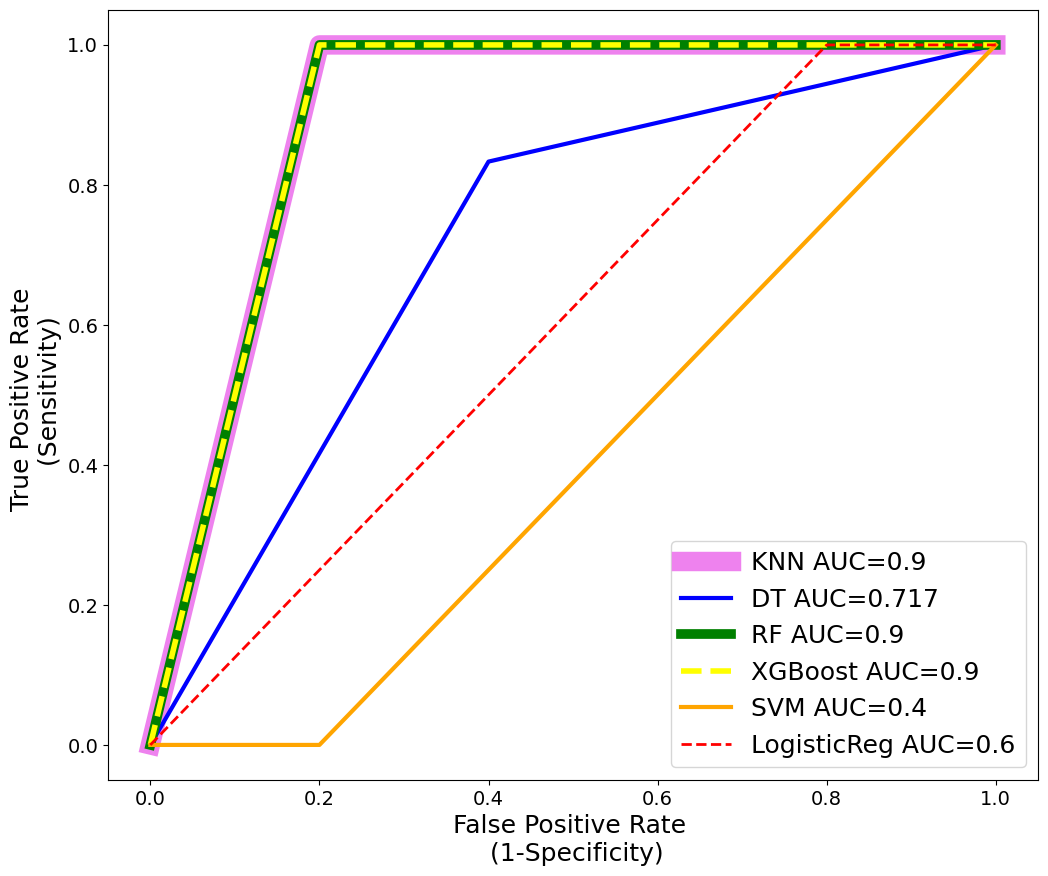

In [36]:
# Different Algorithms with the best parameters
KNN = KNeighborsClassifier(leaf_size=1, metric='manhattan', n_neighbors=5 , weights='distance')
DT = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_leaf=3, min_samples_split=2 , random_state=2023)
rf_clf1 = RandomForestClassifier(criterion='gini', max_depth=2, min_samples_leaf=3, min_samples_split=2 , n_estimators=50, random_state=2023)
XGBoost = xgb.XGBClassifier(learning_rate= 1, max_depth= 3, min_child_weight= 0.5, n_estimators= 100, random_state=2023)
SVM = SVC(C=1, gamma=0.1, kernel='rbf' , random_state=2023)
Logistic = LogisticRegression(C=0.1, l1_ratio=0.3, max_iter=10000, penalty='elasticnet', solver='saga', random_state=2023)


# KNN = KNeighborsClassifier(**KNN_search1_hybrid.best_params_)
# DT= DecisionTreeClassifier(**DT_search1_hybrid.best_params_, random_state=2023)
# rf_clf1 = RandomForestClassifier(**rf_search1_hybrid.best_params_, random_state=2023)
# XGBoost = xgb.XGBClassifier(**XGBoost_search1_hybrid.best_params_, random_state=2023)
# SVM = SVC(**SVM_search1_hybrid.best_params_, random_state=2023)
# Logistic = LogisticRegression(**logit_search1_hybrid.best_params_,max_iter=10000, random_state=2023)

# model fit on train data
KNN.fit(X_train_uncorr, np.ravel(y_train))
DT.fit(X_train_uncorr, y_train)
rf_clf1.fit(X_train_uncorr, np.ravel(y_train))
XGBoost.fit(X_train_uncorr, np.ravel(y_train) )
SVM.fit(X_train_uncorr, np.ravel(y_train))
Logistic.fit(X_train_Regularized, np.ravel(y_train))

# prediction of the model
pred_KNN = KNN.predict(X_test_uncorr)
pred_dt = DT.predict(X_test_uncorr)
pred_RF = rf_clf1.predict(X_test_uncorr)
pred_XGBoost = XGBoost.predict(X_test_uncorr)
pred_svm = SVM.predict(X_test_uncorr)
pred_Logistic = Logistic.predict(X_test_Regularized)

# calculate roc auc for each model
AUC0 = roc_auc_score(y_test, pred_KNN)
AUC1 = roc_auc_score(y_test, pred_dt)
AUC2 = roc_auc_score(y_test, pred_RF)
AUC3 = roc_auc_score(y_test, pred_XGBoost)
AUC4 = roc_auc_score(y_test, pred_svm)
AUC5 = roc_auc_score(y_test, pred_Logistic)

print(f'ROC_AUC for KNN algorithm: {round(AUC0,3)}')
print(f'ROC_AUC for DT algorithm: {round(AUC1,3)}')
print(f'ROC_AUC for RF algorithm: {round(AUC2,3)}')
print(f'ROC_AUC for XGBoost algorithm: {round(AUC3,3)}')
print(f'ROC_AUC for SVM algorithm: {round(AUC4,3)}')
print(f'ROC_AUC for LogisticR algorithm: {round(AUC5,3)}')


# get false and true predictions for each model

fpr0, tpr0, thresholds0 = roc_curve(y_test, pred_KNN)
fpr1, tpr1, thresholds1 = roc_curve(y_test, pred_dt)
fpr2, tpr2, thresholds2 = roc_curve(y_test, pred_RF)
fpr3, tpr3, thresholds3 = roc_curve(y_test, pred_XGBoost)
fpr4, tpr4, thresholds4 = roc_curve(y_test, pred_svm)
fpr5, tpr5, thresholds5 = roc_curve(y_test, pred_Logistic)

# plot roc auc with calculated AUC values
plt.figure(figsize=(12, 10))
plt.plot(fpr0,tpr0, color='violet', label="KNN AUC="+str(round(AUC0, 3)), lw=14)
plt.plot(fpr1,tpr1, color='blue', label="DT AUC="+str(round(AUC1, 3)), lw=3)
plt.plot(fpr2,tpr2, color='green', label="RF AUC="+str(round(AUC2, 3)), lw=7)
plt.plot(fpr3,tpr3, color='yellow', label="XGBoost AUC="+str(round(AUC3, 3)),linestyle = 'dashed', lw=4)
plt.plot(fpr4,tpr4, color='orange', label="SVM AUC="+str(round(AUC4, 3)), lw=3)
plt.plot(fpr5,tpr5, color='red', label="LogisticReg AUC="+str(round(AUC5, 3)),linestyle = 'dashed', lw=2)
plt.xlabel("False Positive Rate \n (1-Specificity)", fontsize= 18)
plt.ylabel("True Positive Rate \n (Sensitivity)", fontsize= 18)
plt.xticks(rotation= 0, fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc=4, prop={'size': 18})

plt.savefig('/home/phoebe/phd/Hybrid_Filter_Graphs/ISSR_annual_conf_2023_ROC_AUC.tiff', dpi=300)
plt.savefig('/home/phoebe/phd/Hybrid_Filter_Graphs/ISSR_annual_conf_2023_ROC_AUC.jpeg', dpi=300)
# plt.savefig('/home/phoebe/phd/Hybrid_Filter_Graphs/AUC_curves_hybrid_Filter.pdf', dpi=800)

KNN: 0.450000 (0.415331)
DT: 0.500000 (0.433013)
RF: 0.600000 (0.374166)
XGB: 0.550000 (0.415331)
SVM: 0.800000 (0.331662)


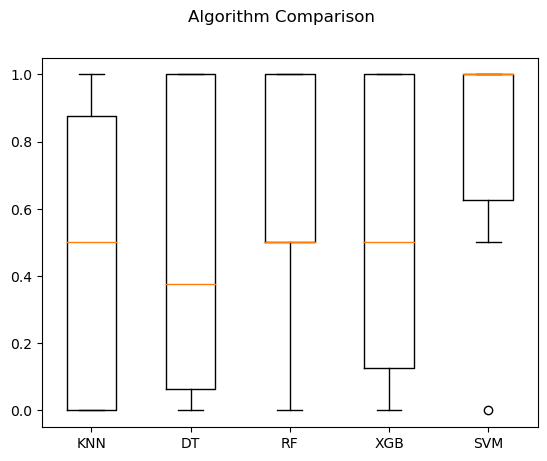

In [37]:
# Models with best tuned hyperparameters:
KNN = KNeighborsClassifier(leaf_size=1, metric='manhattan', n_neighbors=5 , weights='distance')
DT = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_leaf=3, min_samples_split=2 , random_state=2023)
rf_clf1 = RandomForestClassifier(criterion='gini', max_depth=2, min_samples_leaf=3, min_samples_split=2 , n_estimators=50, random_state=2023)
XGBoost = xgb.XGBClassifier(learning_rate= 1, max_depth= 3, min_child_weight= 0.5, n_estimators= 100, random_state=2023)
SVM = SVC(C=1, gamma=0.1, kernel='rbf' , random_state=2023)
# Logistic = LogisticRegression(C=1, l1_ratio=0.3, max_iter=10000, penalty='elasticnet', solver='saga', random_state=2023)
# Logistic = LogisticRegression(C=0.1, l1_ratio=0.3, max_iter=10000, penalty='elasticnet', solver='saga', random_state=2023)

# KNN = KNeighborsClassifier(**KNN_search1_hybrid.best_params_)
# DT= DecisionTreeClassifier(**DT_search1_hybrid.best_params_, random_state=2023)
# rf_clf1 = RandomForestClassifier(**rf_search1_hybrid.best_params_, random_state=2023)
# XGBoost = xgb.XGBClassifier(**XGBoost_search1_hybrid.best_params_, random_state=2023)
# SVM = SVC(**SVM_search1_hybrid.best_params_, random_state=2023)
# Logistic = LogisticRegression(**logit_search1_hybrid.best_params_,max_iter=10000, random_state=2023)


# prepare configuration for cross validation test 
seed = 2023
# prepare models
models = []
models.append(('KNN', KNN))
models.append(('DT', DT))
models.append(('RF', rf_clf1))
models.append(('XGB', XGBoost))
models.append(('SVM', SVM))
# models.append(('Logistic', Logistic))

# evaluate each model in turn
results = []
names = []
scoring = 'roc_auc'
for name, model in models:
    kfold = StratifiedKFold(n_splits=10,shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, X_train_uncorr, np.ravel(y_train), cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

#plt.savefig('/home/phoebe/phd/Box_Plots', dpi=400)

In [38]:
pd.DataFrame(results, index=names)

,0,1,2,3,4,5,6,7,8,9
KNN,0.0,0.50,1.0,0.5,1.0,0.50,0.0,1.0,0.0,0.0
DT,0.0,0.25,1.0,1.0,0.0,0.25,1.0,1.0,0.0,0.5
RF,0.0,0.50,0.5,0.5,0.5,1.00,1.0,1.0,0.0,1.0
XGB,1.0,0.50,0.5,1.0,0.0,0.00,0.0,1.0,0.5,1.0
SVM,0.0,1.00,1.0,1.0,1.0,0.50,1.0,1.0,0.5,1.0


In [39]:
MLA_columns = []
MLA_compare = pd.DataFrame(columns = MLA_columns)

row_index = 0
for name, alg in models:  
    
    predicted = alg.fit(X_train_uncorr, np.ravel(y_train)).predict(X_test_uncorr)
    train_predicted = alg.predict(X_train_uncorr)

    CM = confusion_matrix(y_test,predicted)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    TNR = TN/(TN+FP)
    fnr = FN/(FN+TP)
    fpr = FP/(TN+FP)
  
    CM_train = confusion_matrix(y_train,train_predicted)
    TN_train = CM_train[0][0]
    FN_train = CM_train[1][0]
    TP_train = CM_train[1][1]
    FP_train = CM_train[0][1]
    TNR_train = TN_train/(TN_train+FP_train)
    fnr_train = FN_train/(FN_train+TP_train)
    fpr_train = FP_train/(TN_train+FP_train)

    MLA_name = name
    MLA_compare.loc[row_index,'MLA used'] = MLA_name
    
    MLA_compare.loc[row_index,'Group'] = 'Train'
    
    MLA_compare.loc[row_index, 'Accuracy'] = round(accuracy_score(y_train, train_predicted), 3)
    # MLA_compare.loc[row_index, 'Test Accuracy'] = round(alg.score(X_test_Dup, y_test), 3)

    MLA_compare.loc[row_index, 'ROC-AUC'] = round(roc_auc_score(y_train, train_predicted),3)
    # MLA_compare.loc[row_index, 'Test ROC-AUC'] = round(roc_auc_score(y_test, predicted),3)

    MLA_compare.loc[row_index, 'Precission'] = round(precision_score(y_train, train_predicted),3)
    # MLA_compare.loc[row_index, 'Test Precission'] = round(precision_score(y_test, predicted),3)

    MLA_compare.loc[row_index, 'Recall'] = round(recall_score(y_train, train_predicted),3)
    # MLA_compare.loc[row_index, 'Test Recall'] = round(recall_score(y_test, predicted),3)
    
    MLA_compare.loc[row_index, 'Specificity'] = round(TNR_train,3)
    # MLA_compare.loc[row_index, 'Test Specificity'] = round(TNR,3)

    MLA_compare.loc[row_index, 'F1_score'] = round(f1_score(y_train,train_predicted),3)
    # MLA_compare.loc[row_index, 'Test F1_score'] = round(f1_score(y_test,predicted),3)

    MLA_compare.loc[row_index, 'FNR "Type II error"'] = round(fnr_train,3)
    # MLA_compare.loc[row_index, 'Test FNR "Type II error" '] = round(fnr,3)

    MLA_compare.loc[row_index, 'FPR "Type I error"'] = round(fpr_train,3)
    # MLA_compare.loc[row_index, 'Test FPR "Type I error" '] = round(fpr,3)

    row_index+=1

    
    
Logistic = LogisticRegression(C=0.1, l1_ratio=0.3, max_iter=10000, penalty='elasticnet', solver='saga', random_state=2023)
Logistic.fit(X_train_Regularized, np.ravel(y_train))

pred_Logistic = Logistic.predict(X_test_Regularized)
Log_train_predicted = Logistic.predict(X_train_Regularized)

CM = confusion_matrix(y_test,pred_Logistic)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
TNR = TN/(TN+FP)
fnr = FN/(FN+TP)
fpr = FP/(TN+FP)

CM_train = confusion_matrix(y_train, Log_train_predicted)
TN_train = CM_train[0][0]
FN_train = CM_train[1][0]
TP_train = CM_train[1][1]
FP_train = CM_train[0][1]
TNR_train = TN_train/(TN_train+FP_train)
fnr_train = FN_train/(FN_train+TP_train)
fpr_train = FP_train/(TN_train+FP_train)


MLA_compare.loc[row_index,'MLA used'] = 'LR'
MLA_compare.loc[row_index,'Group'] = 'Train'

MLA_compare.loc[row_index, 'Accuracy'] = round(accuracy_score(y_train, Log_train_predicted), 3)
# MLA_compare.loc[row_index, 'Test Accuracy'] = round(Logistic.score(X_test_Regularized, y_test), 3)

MLA_compare.loc[row_index, 'ROC-AUC'] = round(roc_auc_score(y_train, Log_train_predicted),3)
# MLA_compare.loc[row_index, 'Test ROC-AUC'] = round(roc_auc_score(y_test, pred_Logistic),3)

MLA_compare.loc[row_index, 'Precission'] = round(precision_score(y_train, Log_train_predicted),3)
# MLA_compare.loc[row_index, 'Test Precission'] = round (precision_score(y_test, pred_Logistic),3)

MLA_compare.loc[row_index, 'Recall'] = round (recall_score(y_train, Log_train_predicted),3) 
# MLA_compare.loc[row_index, 'Test Recall'] = round (recall_score(y_test, pred_Logistic),3)

MLA_compare.loc[row_index, 'Specificity'] = round(TNR_train,3)
# MLA_compare.loc[row_index, 'Test Specificity'] = round(TNR,3)

MLA_compare.loc[row_index, 'F1_score'] = round(f1_score(y_train,Log_train_predicted),3)
# MLA_compare.loc[row_index, 'Test F1_score'] = round(f1_score(y_test,pred_Logistic),3)
    
MLA_compare.loc[row_index, 'FNR "Type II error"'] = round(fnr_train,3)
# MLA_compare.loc[row_index, 'Test FNR "Type II error" '] = round(fnr,3)

MLA_compare.loc[row_index, 'FPR "Type I error"'] = round(fpr_train,3)
# MLA_compare.loc[row_index, 'Test FPR "Type I error" '] = round(fpr,3)
MLA_compare

,MLA used,Group,Accuracy,ROC-AUC,Precission,Recall,Specificity,F1_score,"FNR ""Type II error""","FPR ""Type I error"""
0,KNN,Train,0.933,0.929,0.889,1.000,0.857,0.941,0.000,0.143
1,DT,Train,0.867,0.871,0.929,0.812,0.929,0.867,0.188,0.071
2,RF,Train,0.933,0.929,0.889,1.000,0.857,0.941,0.000,0.143
3,XGB,Train,0.933,0.929,0.889,1.000,0.857,0.941,0.000,0.143
4,SVM,Train,0.933,0.929,0.889,1.000,0.857,0.941,0.000,0.143
5,LR,Train,0.733,0.741,0.833,0.625,0.857,0.714,0.375,0.143


In [40]:
row_index += 1
for name, alg in models:  
    
    predicted = alg.fit(X_train_uncorr, np.ravel(y_train)).predict(X_test_uncorr)
    train_predicted = alg.predict(X_train_uncorr)

    CM = confusion_matrix(y_test,predicted)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    TNR = TN/(TN+FP)
    fnr = FN/(FN+TP)
    fpr = FP/(TN+FP)
  
    CM_train = confusion_matrix(y_train,train_predicted)
    TN_train = CM_train[0][0]
    FN_train = CM_train[1][0]
    TP_train = CM_train[1][1]
    FP_train = CM_train[0][1]
    TNR_train = TN_train/(TN_train+FP_train)
    fnr_train = FN_train/(FN_train+TP_train)
    fpr_train = FP_train/(TN_train+FP_train)

    MLA_name = name
    MLA_compare.loc[row_index,'MLA used'] = MLA_name
    
    MLA_compare.loc[row_index,'Group'] = 'Test'

    
    # # MLA_compare.loc[row_index, 'Train Accuracy'] = round(alg.score(X_train_Dup, y_train), 3)
    MLA_compare.loc[row_index, 'Accuracy'] = round(accuracy_score(y_test, predicted), 3)

    # # MLA_compare.loc[row_index, 'Train ROC-AUC'] = round(roc_auc_score(y_train, train_predicted),3)
    MLA_compare.loc[row_index, 'ROC-AUC'] = round(roc_auc_score(y_test, predicted),3)

    # # MLA_compare.loc[row_index, 'Train Precission'] = round(precision_score(y_train, train_predicted),3)
    MLA_compare.loc[row_index, 'Precission'] = round(precision_score(y_test, predicted),3)

    # # MLA_compare.loc[row_index, 'Train Recall'] = round(recall_score(y_train, train_predicted),3)
    MLA_compare.loc[row_index, 'Recall'] = round(recall_score(y_test, predicted),3)
    
    # # MLA_compare.loc[row_index, 'Train Specificity'] = round(TNR_train,3)
    MLA_compare.loc[row_index, 'Specificity'] = round(TNR,3)

    # # MLA_compare.loc[row_index, 'Train F1_score'] = round(f1_score(y_train,train_predicted),3)
    MLA_compare.loc[row_index, 'F1_score'] = round(f1_score(y_test,predicted),3)

    # MLA_compare.loc[row_index, 'Train FNR "Type II error" '] = round(fnr_train,3)
    MLA_compare.loc[row_index, 'FNR "Type II error"'] = round(fnr,3)

    # MLA_compare.loc[row_index, 'Train FPR "Type I error" '] = round(fpr_train,3)
    MLA_compare.loc[row_index, 'FPR "Type I error"'] = round(fpr,3)

    row_index+=1

    
    
Logistic = LogisticRegression(C=0.1, l1_ratio=0.3, max_iter=10000, penalty='elasticnet', solver='saga', random_state=2023)
Logistic.fit(X_train_Regularized, np.ravel(y_train))

pred_Logistic = Logistic.predict(X_test_Regularized)
Log_train_predicted = Logistic.predict(X_train_Regularized)

CM = confusion_matrix(y_test,pred_Logistic)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
TNR = TN/(TN+FP)
fnr = FN/(FN+TP)
fpr = FP/(TN+FP)

CM_train = confusion_matrix(y_train, Log_train_predicted)
TN_train = CM_train[0][0]
FN_train = CM_train[1][0]
TP_train = CM_train[1][1]
FP_train = CM_train[0][1]
TNR_train = TN_train/(TN_train+FP_train)
fnr_train = FN_train/(FN_train+TP_train)
fpr_train = FP_train/(TN_train+FP_train)


MLA_compare.loc[row_index,'MLA used'] = 'LR'
MLA_compare.loc[row_index,'Group'] = 'Test'

# MLA_compare.loc[row_index, 'Train Accuracy'] = round(Logistic.score(X_train_Regularized, y_train), 3)
MLA_compare.loc[row_index, 'Accuracy'] = round(accuracy_score(y_test, pred_Logistic), 3)

# MLA_compare.loc[row_index, 'Train ROC-AUC'] = round(roc_auc_score(y_train, Log_train_predicted),3)
MLA_compare.loc[row_index, 'ROC-AUC'] = round(roc_auc_score(y_test, pred_Logistic),3)

# MLA_compare.loc[row_index, 'Train Precission'] = round(precision_score(y_train, Log_train_predicted),3)
MLA_compare.loc[row_index, 'Precission'] = round (precision_score(y_test, pred_Logistic),3)

# MLA_compare.loc[row_index, 'Train Recall'] = round (recall_score(y_train, Log_train_predicted),3) 
MLA_compare.loc[row_index, 'Recall'] = round (recall_score(y_test, pred_Logistic),3)

# MLA_compare.loc[row_index, 'Train Specificity'] = round(TNR_train,3)
MLA_compare.loc[row_index, 'Specificity'] = round(TNR,3)

# MLA_compare.loc[row_index, 'Train F1_score'] = round(f1_score(y_train,Log_train_predicted),3)
MLA_compare.loc[row_index, 'F1_score'] = round(f1_score(y_test,pred_Logistic),3)
    
# MLA_compare.loc[row_index, 'Train FNR "Type II error" '] = round(fnr_train,3)
MLA_compare.loc[row_index, 'FNR "Type II error"'] = round(fnr,3)

# MLA_compare.loc[row_index, 'Train FPR "Type I error" '] = round(fpr_train,3)
MLA_compare.loc[row_index, 'FPR "Type I error"'] = round(fpr,3)

    
# MLA_compare.sort_values(by = ['Accuracy'], ascending = False, inplace = True)    
MLA_compare
    


,MLA used,Group,Accuracy,ROC-AUC,Precission,Recall,Specificity,F1_score,"FNR ""Type II error""","FPR ""Type I error"""
0,KNN,Train,0.933,0.929,0.889,1.000,0.857,0.941,0.000,0.143
1,DT,Train,0.867,0.871,0.929,0.812,0.929,0.867,0.188,0.071
2,RF,Train,0.933,0.929,0.889,1.000,0.857,0.941,0.000,0.143
3,XGB,Train,0.933,0.929,0.889,1.000,0.857,0.941,0.000,0.143
4,SVM,Train,0.933,0.929,0.889,1.000,0.857,0.941,0.000,0.143
5,LR,Train,0.733,0.741,0.833,0.625,0.857,0.714,0.375,0.143
6,KNN,Test,0.909,0.900,0.857,1.000,0.800,0.923,0.000,0.200
7,DT,Test,0.727,0.717,0.714,0.833,0.600,0.769,0.167,0.400
8,RF,Test,0.909,0.900,0.857,1.000,0.800,0.923,0.000,0.200
9,XGB,Test,0.909,0.900,0.857,1.000,0.800,0.923,0.000,0.200


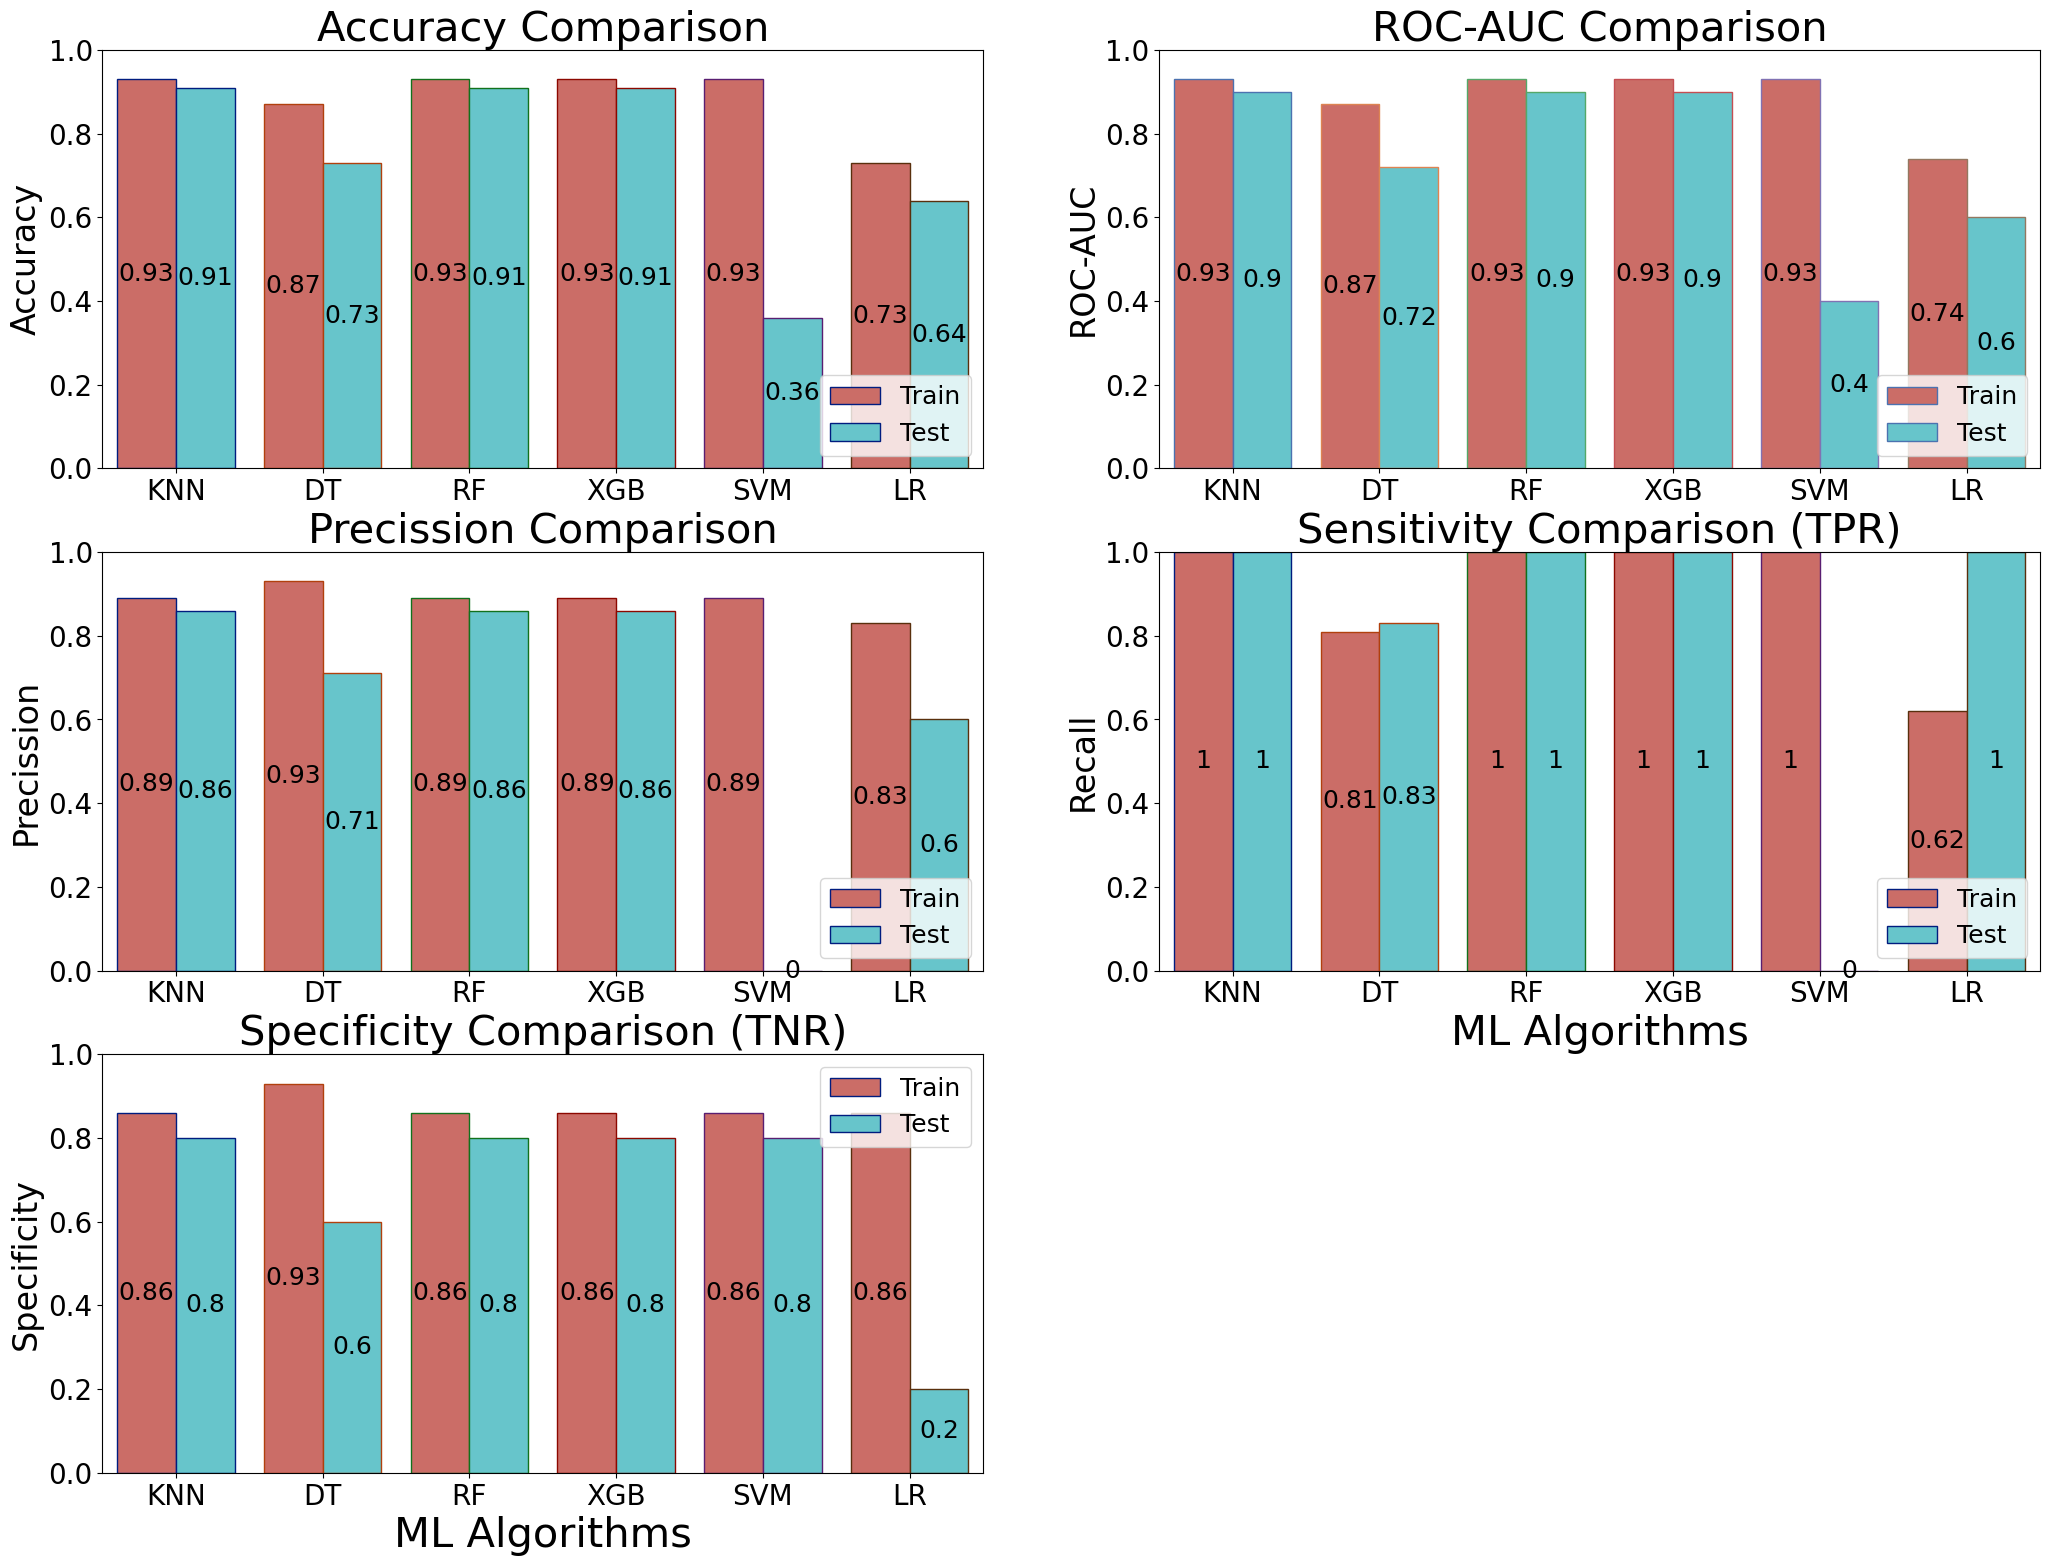

In [41]:
# Creating plot to show the test accuracy
# Creating plot to show the test accuracy
plt.figure(figsize=(25,25))

plt.subplot(4, 2,1)
ax = sns.barplot(x="MLA used", y=round(MLA_compare['Accuracy'],2), hue='Group', data=MLA_compare, palette='hls',width=0.8,edgecolor=sns.color_palette('dark',7))
for container in ax.containers:
    MLA_compare_hue = MLA_compare.loc[MLA_compare['Group']==container.get_label()]
    ax.bar_label(container, label_type='center' ,fontsize = 18)
plt.ylim([0,1.0])
plt.xlabel('')
plt.ylabel('Accuracy',fontsize=24)
plt.xticks(rotation= 0, fontsize=20)
plt.yticks(fontsize=20)
plt.title('Accuracy Comparison', fontsize=30)
plt.legend(loc = 'lower right', fontsize = 18)

plt.subplot(4, 2,2)
ax = sns.barplot(x="MLA used", y=round(MLA_compare["ROC-AUC"],2),hue='Group', data=MLA_compare,palette='hls', width=0.8,edgecolor=sns.color_palette('deep',7))
for container in ax.containers:
    MLA_compare_hue = MLA_compare.loc[MLA_compare['Group']==container.get_label()]
    ax.bar_label(container, label_type='center' ,fontsize = 18)
plt.ylim([0,1.0])
plt.xlabel('')
plt.ylabel('ROC-AUC',fontsize=24)
plt.xticks(rotation= 0, fontsize=20)
plt.yticks(fontsize=20)
plt.title('ROC-AUC Comparison', fontsize=30)
plt.legend(loc = 'lower right',fontsize = 18)

plt.subplot(4, 2,3)
ax = sns.barplot(x="MLA used", y=round(MLA_compare["Precission"],2),hue='Group', data=MLA_compare,palette='hls', width=0.8, edgecolor=sns.color_palette('dark',7))
for container in ax.containers:
    MLA_compare_hue = MLA_compare.loc[MLA_compare['Group']==container.get_label()]
    ax.bar_label(container, label_type='center' ,fontsize = 18)
plt.ylim([0,1.0])
plt.xlabel('')
plt.ylabel('Precission',fontsize=24)
plt.xticks(rotation= 0, fontsize=20)
plt.yticks(fontsize=20)
plt.title('Precission Comparison', fontsize=30)
plt.legend(loc = 'lower right',fontsize = 18)

plt.subplot(4, 2,4)
ax = sns.barplot(x="MLA used", y=round(MLA_compare["Recall"],2),hue='Group', data=MLA_compare,palette='hls', width=0.8, edgecolor=sns.color_palette('dark',7))
for container in ax.containers:
    MLA_compare_hue = MLA_compare.loc[MLA_compare['Group']==container.get_label()]
    ax.bar_label(container, label_type='center' ,fontsize = 18)
plt.ylim([0,1.0])
plt.xlabel('ML Algorithms',fontsize=30)
plt.ylabel('Recall',fontsize=24)
plt.xticks(rotation= 0, fontsize=20)
plt.yticks(fontsize=20)
plt.title('Sensitivity Comparison (TPR)', fontsize=30)
plt.legend(loc = 'lower right',fontsize = 18)

plt.subplot(4, 2,5)
ax = sns.barplot(x="MLA used", y=round(MLA_compare["Specificity"],2),hue='Group', data=MLA_compare,palette='hls', width=0.8, edgecolor=sns.color_palette('dark',7))
for container in ax.containers:
    MLA_compare_hue = MLA_compare.loc[MLA_compare['Group']==container.get_label()]
    ax.bar_label(container, label_type='center' ,fontsize = 18)
plt.ylim([0,1.0])
plt.xlabel('ML Algorithms',fontsize=30)
plt.ylabel('Specificity',fontsize=24)
plt.xticks(rotation= 0, fontsize=20)
plt.yticks(fontsize=20)
plt.title('Specificity Comparison (TNR)', fontsize=30)
plt.legend(loc = 'upper right',fontsize = 18)

# plt.subplot(4, 2,6)
# ax = sns.barplot(x="MLA used", y=round(MLA_compare['F1_score'],2),hue='Group', data=MLA_compare,palette='Spectral', width=0.8, edgecolor=sns.color_palette('dark',7))
# for container in ax.containers:
#     MLA_compare_hue = MLA_compare.loc[MLA_compare['Group']==container.get_label()]
#     ax.bar_label(container, label_type='center' ,fontsize = 18)
# plt.ylim([0,1.0])
# plt.xlabel('')
# plt.ylabel('F1_score',fontsize=24)
# plt.xticks(rotation= 0, fontsize=20)
# plt.yticks(fontsize=20)
# plt.title('F1_score Comparison', fontsize=30)
# plt.legend(loc = 'lower right',fontsize = 18)

# plt.subplot(4, 2,7)
# ax = sns.barplot(x="MLA used", y=round(MLA_compare['FPR "Type I error"'],2),hue='Group', data=MLA_compare,palette='Spectral', width=0.8, edgecolor=sns.color_palette('dark',7))
# for container in ax.containers:
#     MLA_compare_hue = MLA_compare.loc[MLA_compare['Group']==container.get_label()]
#     ax.bar_label(container, label_type='center' ,fontsize = 18)
# plt.ylim([0,1.0])
# plt.xlabel('ML Algorithms',fontsize=30)
# plt.ylabel('FPR "Type I error"',fontsize=24)
# plt.xticks(rotation= 0, fontsize=20)
# plt.yticks(fontsize=20)
# plt.title('FPR Comparison', fontsize=30)
# plt.legend(loc = 'upper right', fontsize = 18)

# plt.subplot(4, 2,8)
# ax = sns.barplot(x="MLA used", y=round(MLA_compare['FNR "Type II error"'],2),hue='Group', data=MLA_compare,palette='Spectral', width=0.8, edgecolor=sns.color_palette('dark',7))
# for container in ax.containers:
#     MLA_compare_hue = MLA_compare.loc[MLA_compare['Group']==container.get_label()]
#     ax.bar_label(container, label_type='center' ,fontsize = 18)
# plt.ylim([0,1.0])
# plt.xlabel('ML Algorithms',fontsize=30)
# plt.ylabel('FNR "Type II error"',fontsize=24)
# plt.xticks(rotation= 0, fontsize=20)
# plt.yticks(fontsize=20)
# plt.title('FNR Comparison', fontsize=30)
# plt.legend(loc = 'upper right',fontsize = 18)


plt.savefig('/home/phoebe/phd/Hybrid_Filter_Graphs/ISSR_annual_conf_2023_ALL_Test_metrics.tiff', dpi=300)
plt.savefig('/home/phoebe/phd/Hybrid_Filter_Graphs/ISSR_annual_conf_2023_ALL_Test_metrics.jpeg', dpi=300)
# plt.savefig('/home/phoebe/phd/Hybrid_Filter_Graphs/ALL_Test_metrics_hybrid.pdf', dpi=800)